In [1]:
from pylab import *
from Bio import SeqIO
import matplotlib.pyplot as plt
from Bio.PDB import PDBParser
from Bio.PDB.DSSP import DSSP
import pandas as pd
import re
import numpy as np
pd.options.mode.chained_assignment = None 
import io
from io import StringIO

In [2]:
#Uniprot API
import re
import time
import json
import zlib
from xml.etree import ElementTree
from urllib.parse import urlparse, parse_qs, urlencode
import requests
from requests.adapters import HTTPAdapter, Retry


POLLING_INTERVAL = 3
API_URL = "https://rest.uniprot.org"


retries = Retry(total=5, backoff_factor=0.25, status_forcelist=[500, 502, 503, 504])
session = requests.Session()
session.mount("https://", HTTPAdapter(max_retries=retries))


def check_response(response):
    try:
        response.raise_for_status()
    except requests.HTTPError:
        print(response.json())
        raise


def submit_id_mapping(from_db, to_db, ids):
    request = requests.post(
        f"{API_URL}/idmapping/run",
        data={"from": from_db, "to": to_db, "ids": ",".join(ids)},
    )
    check_response(request)
    return request.json()["jobId"]


def get_next_link(headers):
    re_next_link = re.compile(r'<(.+)>; rel="next"')
    if "Link" in headers:
        match = re_next_link.match(headers["Link"])
        if match:
            return match.group(1)


def check_id_mapping_results_ready(job_id):
    while True:
        request = session.get(f"{API_URL}/idmapping/status/{job_id}")
        check_response(request)
        j = request.json()
        if "jobStatus" in j:
            if j["jobStatus"] == "RUNNING":
                print(f"Retrying in {POLLING_INTERVAL}s")
                time.sleep(POLLING_INTERVAL)
            else:
                raise Exception(j["jobStatus"])
        else:
            return bool(j["results"] or j["failedIds"])


def get_batch(batch_response, file_format, compressed):
    batch_url = get_next_link(batch_response.headers)
    while batch_url:
        batch_response = session.get(batch_url)
        batch_response.raise_for_status()
        yield decode_results(batch_response, file_format, compressed)
        batch_url = get_next_link(batch_response.headers)


def combine_batches(all_results, batch_results, file_format):
    if file_format == "json":
        for key in ("results", "failedIds"):
            if key in batch_results and batch_results[key]:
                all_results[key] += batch_results[key]
    elif file_format == "tsv":
        return all_results + batch_results[1:]
    else:
        return all_results + batch_results
    return all_results


def get_id_mapping_results_link(job_id):
    url = f"{API_URL}/idmapping/details/{job_id}"
    request = session.get(url)
    check_response(request)
    return request.json()["redirectURL"]


def decode_results(response, file_format, compressed):
    if compressed:
        decompressed = zlib.decompress(response.content, 16 + zlib.MAX_WBITS)
        if file_format == "json":
            j = json.loads(decompressed.decode("utf-8"))
            return j
        elif file_format == "tsv":
            return [line for line in decompressed.decode("utf-8").split("\n") if line]
        elif file_format == "xlsx":
            return [decompressed]
        elif file_format == "xml":
            return [decompressed.decode("utf-8")]
        else:
            return decompressed.decode("utf-8")
    elif file_format == "json":
        return response.json()
    elif file_format == "tsv":
        return [line for line in response.text.split("\n") if line]
    elif file_format == "xlsx":
        return [response.content]
    elif file_format == "xml":
        return [response.text]
    return response.text


def get_xml_namespace(element):
    m = re.match(r"\{(.*)\}", element.tag)
    return m.groups()[0] if m else ""


def merge_xml_results(xml_results):
    merged_root = ElementTree.fromstring(xml_results[0])
    for result in xml_results[1:]:
        root = ElementTree.fromstring(result)
        for child in root.findall("{http://uniprot.org/uniprot}entry"):
            merged_root.insert(-1, child)
    ElementTree.register_namespace("", get_xml_namespace(merged_root[0]))
    return ElementTree.tostring(merged_root, encoding="utf-8", xml_declaration=True)


def print_progress_batches(batch_index, size, total):
    n_fetched = min((batch_index + 1) * size, total)
    print(f"Fetched: {n_fetched} / {total}")


def get_id_mapping_results_search(url):
    parsed = urlparse(url)
    query = parse_qs(parsed.query)
    file_format = query["format"][0] if "format" in query else "json"
    if "size" in query:
        size = int(query["size"][0])
    else:
        size = 500
        query["size"] = size
    compressed = (
        query["compressed"][0].lower() == "true" if "compressed" in query else False
    )
    parsed = parsed._replace(query=urlencode(query, doseq=True))
    url = parsed.geturl()
    request = session.get(url)
    check_response(request)
    results = decode_results(request, file_format, compressed)
    total = int(request.headers["x-total-results"])
    print_progress_batches(0, size, total)
    for i, batch in enumerate(get_batch(request, file_format, compressed), 1):
        results = combine_batches(results, batch, file_format)
        print_progress_batches(i, size, total)
    if file_format == "xml":
        return merge_xml_results(results)
    return results




# Functions for Data Wrangling #

In [3]:
import Peptide_Analysis as PA# has to be in the same directory

In [4]:
def list_of_Gene_Names(csv):
    "Writes a list of Unique Protein Names in txt format to obtain uniprot ID and sequence"
    daf = pd.read_csv(csv, sep="\t" ,low_memory=False)#read csv file
    daf = daf.drop_duplicates(subset='Sequence', keep="first")#remove duplicates
    all_protein= []   #list of protein names
    for proteins in daf['Proteins']:
        all_protein.append(proteins.split(","))
    protein_names = [] #list of all unique protein names
    for p in all_protein:
        if p not in protein_names:
            protein_names.append(p)
    print(len(all_protein))
    print(len(protein_names))
    new_list = [sublist[0] for sublist in protein_names]
    # Map gene names to UniProtKB IDs
    try:
        job_id = submit_id_mapping(from_db="Gene_Name", to_db="UniProtKB", ids= new_list)
        if check_id_mapping_results_ready(job_id):
            link = get_id_mapping_results_link(job_id)
            results = get_id_mapping_results_search(link + "?format=tsv")
            lst_split = [s.split('\t') for s in results]
            daf = pd.DataFrame(lst_split[1:], columns=lst_split[0])
            daf = daf[daf["Organism"] == "Homo sapiens (Human)"]
            print(daf)
            daf.to_csv('Uniprot/Python_API _ProteinNames.csv', index = False, header=True)
    except Exception as e:
        print(f"An error occurred while mapping gene names to UniProtKB IDs: {e}")
    with open('protein_names.txt', 'w') as f: 
        for proteins in new_list:
                f.write("%s\n" % proteins)
    

In [5]:
#list_of_Gene_Names("C:\\Users\\ahmad\\Dropbox\\PC\\Documents\\QMUL\\Research Project\\Proteomics\\Proteomics-extended\\data\\proteusAll.tsv")

In [6]:
def RAW_Data_To_Dataframe(RawData, ID, protein_seq, protein_name):
    """Convert Raw datas into Final Data Frame"""
    # Wrangle Proteus dataframe
    df = pd.read_csv(RawData, sep="\t", low_memory=False)  # read in the dataframe
    df = df.drop_duplicates(subset='Sequence', keep="first") #REMOVE DUPLICATES
    df= df.filter(['Sequence', 'Proteins', 'Modifications']) #filter dataframe to only include protein names and sequences
    # Wrangle proteinID dataframe
    proteinID= pd.read_csv(ID, sep="\t" ,low_memory=False)
    proteinID=proteinID.rename(columns={'From': 'ProteinID'})
    proteinID = proteinID.drop_duplicates(subset='ProteinID', keep="first")
    df = df.merge(proteinID, left_on='Proteins', right_on='ProteinID', how='left') #merge protein names with protein ID
    df= df.filter(['Sequence', 'Proteins', 'Modifications' , 'Entry']) #remove columns that are not needed
    df= df[df['Entry'].notnull()] #remove rows with null values
    with open(protein_seq) as fasta_file:  # Will close handle cleanly
        identifiers = []
        seq = []
        for seq_record in SeqIO.parse(fasta_file, 'fasta'):  # (generator)
            identifiers.append(seq_record.id)
            seq.append(seq_record.seq)
    new_df = pd.DataFrame({'Identifier': identifiers, 'Protein_Sequence': seq}) #create new dataframe with identifiers and sequences
    proteinID = r'sp\|(.*)\|.*' #regular expression to extract protein ID
    new_df['Identifier'] = [re.sub(proteinID, r'\1', x) for x in new_df['Identifier']] #remove protein ID from identifier
    new_df['Protein_Sequence'] = new_df['Protein_Sequence'].apply(PA.list_to_string) #convert list to string
    new_df['Protein_Sequence'] = new_df['Protein_Sequence'].str.replace(',', '') #remove ',' from string
    df= df.merge(new_df, left_on='Entry', right_on='Identifier', how='left') #merge protein names with protein ID
    df['Check'] = df.apply(PA.check_Sequence_in_Protein_Sequence, axis=1) #apply function to dataframe
    print(df['Check'].value_counts())
    df = df[df.Check != False] #remove rows that are false
    df['start']= df.apply(lambda row: PA.peptide_start_position(row['Protein_Sequence'], row['Sequence']), axis=1) #apply function to dataframe
    df['end']= df.apply(lambda row: PA.peptide_end_position(row['Protein_Sequence'], row['Sequence']), axis=1) 
    df['last_AA']= df.apply(lambda row: PA.find_last_AA(row['Protein_Sequence'], row['Sequence']), axis=1)
    df['next_AA']= df.apply(lambda row: PA.find_peptide(row['Protein_Sequence'], row['Sequence']), axis=1)
    df = df[df.Protein_Sequence != ''] #remove rows with empty protein sequences
    df['extended_peptide']= df.apply(lambda row: PA.next_2_AA(row['Protein_Sequence'], row['Sequence']), axis=1) #add last AA of peptide and next AA
    df['cleavage_sites'] = df['Sequence'].str.findall(r".(?:(?<![KR](?!P)).)*") #find all cleavage sites in peptide sequence
    df['cleavage_sites'] = [','.join(map(str, l)) for l in df['cleavage_sites']] #convert list to string
    df['missed'] = df.cleavage_sites.str.count(',') #count number of missed cleavage sites
    cleavage= r".*?([RK]),.*"
    second_cleavage= r".*[RK],.*([RK]),.*"
    df['MS_AA']= df.cleavage_sites.str.findall(cleavage)
    df['MS_AA']= df['MS_AA'].apply(PA.list_to_string)
    df['2nd_cleavage']= df.cleavage_sites.str.findall(second_cleavage)
    df['2nd_cleavage']= df['2nd_cleavage'].apply(PA.list_to_string)
    missed_cleavage= r".*?([RK]),.*"
    df['cs_split'] = df['cleavage_sites'].apply(PA.split_Cleavage_sites) #split cleavage sites
    df['first_half']= df['cs_split'].apply(lambda x: x[0]) # first half of cleavage sites
    df['second_half']= df['cs_split'].apply(PA.second_split) #second half of cleavage sites
    df['position_MS']= df.apply(lambda row: PA.cs_split(row['first_half'], row['start'], row['MS_AA']), axis=1)
    df['2nd_MS'] = df.apply(lambda row: PA.split_second(row['second_half'], row['position_MS'], row['2nd_cleavage']), axis=1)
    df= df.rename({'Entry':'ProteinID'}, axis=1)
    df = df.filter(['Sequence', 'ProteinID','Modifications', 'start', 'end', 'cleavage_sites','MS_AA','position_MS', 'missed'])
    df.cleavage_sites = df.cleavage_sites.str.split(',')                                                                
    df= df.explode('cleavage_sites')
    df['MS_AA'] = df.apply(lambda row: PA.fill_empty_MS_AA(row), axis=1)
    df = df[df.missed != 2]
    df['ProteinID_s'] = df['ProteinID'].shift(1)
    df['start_s'] = df['start'].shift(1)
    df['end_s'] = df['end'].shift(1)
    df['duplicate'] = (df['ProteinID'] == df['ProteinID_s']) & (df['start'] == df['start_s']) & (df['end'] == df['end_s'])
    df = df.apply(lambda row: PA.change_values(row), axis=1) #apply function to change values
    df = df.apply(lambda row: PA.fill_empty_position_MS(row), axis=1)
    df= df.rename({'MS_AA':'Last_AA', 'missed':'Cleavage', 'position_MS':'LastAA_position' }, axis=1)
    df = df.filter(['Sequence', 'ProteinID','Modifications', 'start', 'end', 'cleavage_sites','Last_AA','LastAA_position', 'Cleavage'])
    df.to_csv('MS1_df.csv', index = False, header=True) #write to csv file
    result = df.loc[df["ProteinID"] == protein_name]
    if protein_name=='None':
        return df
    else:
        return result
    
    

        

In [7]:
def RAW_Data_To_Kelis_Rule(RawData, ID, protein_seq):
    """Convert Raw datas into Final Data Frame"""
    # Wrangle Proteus dataframe
    df = pd.read_csv(RawData, sep="\t", low_memory=False)  # read in the dataframe
    df = df.drop_duplicates(subset='Sequence', keep="first") #REMOVE DUPLICATES
    df= df.filter(['Sequence', 'Proteins', 'Modifications']) #filter dataframe to only include protein names and sequences
    # Wrangle proteinID dataframe
    proteinID= pd.read_csv(ID, sep="\t" ,low_memory=False)
    proteinID=proteinID.rename(columns={'From': 'ProteinID'})
    proteinID = proteinID.drop_duplicates(subset='ProteinID', keep="first")
    df = df.merge(proteinID, left_on='Proteins', right_on='ProteinID', how='left') #merge protein names with protein ID
    df= df.filter(['Sequence', 'Proteins', 'Modifications' , 'Entry']) #remove columns that are not needed
    df= df[df['Entry'].notnull()] #remove rows with null values
    with open(protein_seq) as fasta_file:  # Will close handle cleanly
        identifiers = []
        seq = []
        for seq_record in SeqIO.parse(fasta_file, 'fasta'):  # (generator)
            identifiers.append(seq_record.id)
            seq.append(seq_record.seq)
    new_df = pd.DataFrame({'Identifier': identifiers, 'Protein_Sequence': seq}) #create new dataframe with identifiers and sequences
    proteinID = r'sp\|(.*)\|.*' #regular expression to extract protein ID
    new_df['Identifier'] = [re.sub(proteinID, r'\1', x) for x in new_df['Identifier']] #remove protein ID from identifier
    new_df['Protein_Sequence'] = new_df['Protein_Sequence'].apply(PA.list_to_string) #convert list to string
    new_df['Protein_Sequence'] = new_df['Protein_Sequence'].str.replace(',', '') #remove ',' from string
    df= df.merge(new_df, left_on='Entry', right_on='Identifier', how='left') #merge protein names with protein ID
    df['Check'] = df.apply(PA.check_Sequence_in_Protein_Sequence, axis=1) #apply function to dataframe
    df = df[df.Check != False] #remove rows that are false
    df['start']= df.apply(lambda row: PA.peptide_start_position(row['Protein_Sequence'], row['Sequence']), axis=1) #apply function to dataframe
    df['end']= df.apply(lambda row: PA.peptide_end_position(row['Protein_Sequence'], row['Sequence']), axis=1) 
    df['last_AA']= df.apply(lambda row: PA.find_last_AA(row['Protein_Sequence'], row['Sequence']), axis=1)
    df['next_AA']= df.apply(lambda row: PA.find_peptide(row['Protein_Sequence'], row['Sequence']), axis=1)
    df = df[df.Protein_Sequence != ''] #remove rows with empty protein sequences
    p_count= (df['next_AA'] == 'P').sum() #count number of P's
    p_count
    reg= r".*[RK]P.*" #regular expression to find R|K P
    df_RK= df[df.Sequence.str.match(reg)] #filter dataframe to only include peptides with R|K P
    df['extended_peptide']= df.apply(lambda row: PA.next_2_AA(row['Protein_Sequence'], row['Sequence']), axis=1) #add last AA of peptide and next AA
    df_p= df.loc[lambda x: x['extended_peptide'].str.contains(reg , regex=True)] #find rows that contain R|K P
    total= len(df_RK) #Sum of rows with R|K P pattern in peptide sequence 
    print(total)
    print(p_count)
    y_axis= np.array([p_count, total]) #create array of y axis values
    mycolors = ["#38a66a","#204687"] #create array of colors
    plt.figure(figsize=(8, 8)) #set figure size
    plt.pie(y_axis, labels=["Cleavage", "No Cleavage"], autopct='%1.1f%%' , colors=mycolors, startangle=90, explode=[0.3, 0], radius=1.2,) #plot pie chart
    plt.legend(loc='upper right', bbox_to_anchor=(1.1, 1.1), fontsize=12, ncol=2) #set legend      
    plt.show() #show plot
    

please load data: C:\\Users\\ahmad\\Dropbox\\PC\\Documents\\QMUL\\Research Project\\Proteomics\\Proteomics-extended\\data\\proteusAll.tsv
please load IDs: C:\\Users\\ahmad\\Dropbox\\PC\\Documents\\QMUL\\Research Project\\Proteomics\\Proteomics-extended\\data\\UniProtKB-Swiss-Prot\\ID.tsv
please load protein_seq: C:\\Users\\ahmad\\Documents\\QMUL\\Research Project\\Proteomics\\Proteomics-extended\\data\\UniProtKB-Swiss-Prot\\protein_seq.fasta


2193
392


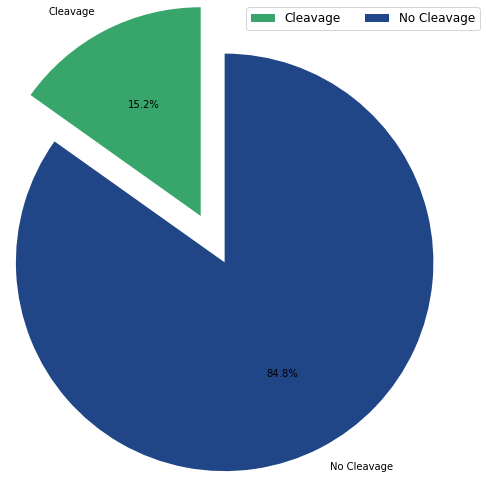

In [8]:
#C:\\Users\\ahmad\\Documents\\QMUL\\Research Project\\Proteomics\\Proteomics-extended\\data\\proteusAllA2.tsv
#RawData: C:\\Users\\ahmad\\Dropbox\\PC\\Documents\\QMUL\\Research Project\\Proteomics\\Proteomics-extended\\data\\proteusAll.tsv
#ID: C:\\Users\\ahmad\\Dropbox\\PC\\Documents\\QMUL\\Research Project\\Proteomics\\Proteomics-extended\\data\\UniProtKB-Swiss-Prot\\ID.tsv
#protein_seq: C:\\Users\\ahmad\\Documents\\QMUL\\Research Project\\Proteomics\\Proteomics-extended\\data\\UniProtKB-Swiss-Prot\\protein_seq.fasta


Data=input("please load data:")
IDs=input("please load IDs:")
protein_seq=input("please load protein_seq:")


RAW_Data_To_Kelis_Rule(Data,IDs,protein_seq)



In [9]:
#RawData: C:\\Users\\ahmad\\Dropbox\\PC\\Documents\\QMUL\\Research Project\\Proteomics\\Proteomics-extended\\data\\proteusAll.tsv
#ID: C:\\Users\\ahmad\\Dropbox\\PC\\Documents\\QMUL\\Research Project\\Proteomics\\Proteomics-extended\\data\\UniProtKB-Swiss-Prot\\ID.tsv
#protein_seq: C:\\Users\\ahmad\\Documents\\QMUL\\Research Project\\Proteomics\\Proteomics-extended\\data\\UniProtKB-Swiss-Prot\\protein_seq.fasta
#protein_name: type None

Data=input("please load data:")
IDs=input("please load IDs:")
protein_seq=input("please load protein_seq:")
protein_name=input("input protein name:")

RAW_Data_To_Dataframe(Data,IDs,protein_seq,protein_name)

please load data: C:\\Users\\ahmad\\Dropbox\\PC\\Documents\\QMUL\\Research Project\\Proteomics\\Proteomics-extended\\data\\proteusAll.tsv
please load IDs: C:\\Users\\ahmad\\Dropbox\\PC\\Documents\\QMUL\\Research Project\\Proteomics\\Proteomics-extended\\data\\UniProtKB-Swiss-Prot\\ID.tsv
please load protein_seq: C:\\Users\\ahmad\\Documents\\QMUL\\Research Project\\Proteomics\\Proteomics-extended\\data\\UniProtKB-Swiss-Prot\\protein_seq.fasta
input protein name: None


True     40181
False     1382
Name: Check, dtype: int64


,Sequence,ProteinID,Modifications,start,end,cleavage_sites,Last_AA,LastAA_position,Cleavage
0,AAAAAAAATMALAAPSSPTPESPTMLTK,Q9NQS7,Unmodified,127,154,AAAAAAAATMALAAPSSPTPESPTMLTK,K,154,0
1,AAAAAAAGDSDSWDADAFSVEDPVR,O75822,Acetyl (Protein N-term),2,26,AAAAAAAGDSDSWDADAFSVEDPVR,R,26,0
2,AAAAAAAGDSDSWDADAFSVEDPVRK,O75822,Acetyl (Protein N-term),2,27,AAAAAAAGDSDSWDADAFSVEDPVR,R,26,1
2,AAAAAAAGDSDSWDADAFSVEDPVRK,O75822,Acetyl (Protein N-term),2,27,K,K,27,0
3,AAAAAAALQAK,P36578,Unmodified,354,364,AAAAAAALQAK,K,364,0
...,...,...,...,...,...,...,...,...,...
41558,YYTEFPTVLDITAEDPSK,O14929,Unmodified,263,280,YYTEFPTVLDITAEDPSK,K,280,0
41559,YYTGNYDQYVK,Q9UG63,Unmodified,305,315,YYTGNYDQYVK,K,315,0
41560,YYTLEEIQK,P00167,Unmodified,11,19,YYTLEEIQK,K,19,0
41561,YYTLFGR,P07814,Unmodified,1504,1510,YYTLFGR,R,1510,0


# Feature Calculation #

In [10]:
from pylab import *
from Bio import SeqIO
import matplotlib.pyplot as plt
import seaborn as sns 
from Bio.PDB import PDBParser
from Bio.PDB.DSSP import DSSP
import pandas as pd
import os
import re
import gzip
import shutil
import glob
import numpy as np
import scipy.stats as stats
import pylab as pl
import csv
from Bio.PDB.SASA import ShrakeRupley

In [11]:
df = pd.read_csv("C:\\Users\\ahmad\\Dropbox\\PC\\Documents\\QMUL\\Research Project\\Proteomics\\Proteomics-extended\\MS1_df.csv")   # read in the dataframe
df.fillna('', inplace=True)   # replace NaN with empty string

In [12]:
def dssp_file_df(file): # function to read in the dssp file and return a dataframe
    p = PDBParser() # create a PDB parser
    structure = p.get_structure(f"{file}", file) # get the structure from the PDB file
    model = structure[0]#  get the first model from the structure
    dssp = DSSP(model, file) # get the DSSP from the model
    df= pd.DataFrame(dssp)# create a dataframe from the DSSP
    df.columns = ["dssp index", "amino acid", "secondary structure", "relative ASA", "phi", "psi", "NH01R", "NH01E", "ONH1", "ONHE", "NH2R",
    "NO2E", "ONH2R", "ONH2E"] # naming the columns
    return df # return the dataframe

In [13]:
def dssp_df_calcualtion(df): # function to calculate the secondary structure and relative ASA
    relative_asa = [] # create a list to store the relative ASA
    secondary_structure = []    # create a list to store the secondary structure
    phi = []    # create a list to store the phi
    psi = []    # create a list to store the psi
    NH01R = []  # create a list to store the NH01R
    NH01E = []  # create a list to store the NH01E
    ONH1 = []   # create a list to store the ONH1
    ONHE = []   # create a list to store the ONHE
    NH2R = []   # create a list to store the NH2R
    NO2E = []   # create a list to store the NO2E
    ONH2R = []  # create a list to store the ONH2R
    ONH2E = []  # create a list to store the ONH2E



    for i,j in df.iterrows():   # loop through the dataframe
        filename= f'AF-{j["ProteinID"]}-F1-model_v4.pdb' # create the filename
        if filename in os.listdir('C:\\Users\\ahmad\\Dropbox\\PC\\Documents\\QMUL\\Research Project\\Proteomics\\Proteomics-extended\\data\\proteome'):   # if the filename is in the human proteome folder
            print(filename)

            df_dssp= dssp_file_df(f'C:\\Users\\ahmad\\Dropbox\\PC\\Documents\\QMUL\\Research Project\\Proteomics\\Proteomics-extended\\data\\proteome\\{filename}\\{filename}') # read in the dssp file
            if j['LastAA_position'] in df_dssp['dssp index']: # if the last AA position is in the dssp file
                relative_asa.append(df_dssp[df_dssp['dssp index'] == j['LastAA_position']]['relative ASA'].values[0]) # append the relative ASA
                secondary_structure.append(df_dssp[df_dssp['dssp index'] == j['LastAA_position']]['secondary structure'].values[0]) # append the secondary structure
                phi.append(df_dssp[df_dssp['dssp index'] == j['LastAA_position']]['phi'].values[0]) # append the phi
                psi.append(df_dssp[df_dssp['dssp index'] == j['LastAA_position']]['psi'].values[0]) # append the psi
                NH01R.append(df_dssp[df_dssp['dssp index'] == j['LastAA_position']]['NH01R'].values[0]) # append the NH01R
                NH01E.append(df_dssp[df_dssp['dssp index'] == j['LastAA_position']]['NH01E'].values[0]) # append the NH01E
                ONH1.append(df_dssp[df_dssp['dssp index'] == j['LastAA_position']]['ONH1'].values[0])   # append the ONH1
                ONHE.append(df_dssp[df_dssp['dssp index'] == j['LastAA_position']]['ONHE'].values[0])   # append the ONHE
                NH2R.append(df_dssp[df_dssp['dssp index'] == j['LastAA_position']]['NH2R'].values[0])   # append the NH2R
                NO2E.append(df_dssp[df_dssp['dssp index'] == j['LastAA_position']]['NO2E'].values[0])   # append the NO2E
                ONH2R.append(df_dssp[df_dssp['dssp index'] == j['LastAA_position']]['ONH2R'].values[0]) # append the ONH2R
                ONH2E.append(df_dssp[df_dssp['dssp index'] == j['LastAA_position']]['ONH2E'].values[0]) # append the ONH2E


            else: # if the last AA position is not in the dssp file
                relative_asa.append('') # append empty string
                secondary_structure.append('')
                phi.append('')
                psi.append('')
                NH01R.append('')
                NH01E.append('')
                ONH1.append('')
                ONHE.append('')
                NH2R.append('')
                NO2E.append('')
                ONH2R.append('')
                ONH2E.append('')
        else:   # if the filename is not in the human proteome folder
            relative_asa.append('') # append empty string
            secondary_structure.append('')  
            phi.append('')
            psi.append('')
            NH01R.append('')
            NH01E.append('')
            ONH1.append('')
            ONHE.append('')
            NH2R.append('')
            NO2E.append('')
            ONH2R.append('')
            ONH2E.append('')


    df['secondary_structure'] = secondary_structure # add the secondary structure to the dataframe
    df['relative ASA'] = relative_asa
    df['phi'] = phi
    df['psi'] = psi
    df['NH01R'] = NH01R
    df['NH01E'] = NH01E
    df['ONH1'] = ONH1
    df['ONHE'] = ONHE
    df['NH2R'] = NH2R
    df['NO2E'] = NO2E
    df['ONH2R'] = ONH2R
    df['ONH2E'] = ONH2E
    return df.to_csv('df_dssp3.csv', index=False)   # return the dataframe to a csv file

In [14]:
#df=dssp_df_calcualtion(df)

In [15]:
df=pd.read_csv("C:\\Users\\ahmad\\Dropbox\\PC\\Documents\\QMUL\\Research Project\\Proteomics\\Proteomics-extended\\df_dssp3.csv")
df

,Sequence,ProteinID,Modifications,start,end,cleavage_sites,Last_AA,LastAA_position,Cleavage,secondary_structure,...,phi,psi,NH01R,NH01E,ONH1,ONHE,NH2R,NO2E,ONH2R,ONH2E
0,AAAAAAAATMALAAPSSPTPESPTMLTK,Q9NQS7,Unmodified,127,154,AAAAAAAATMALAAPSSPTPESPTMLTK,K,154,0,-,...,-47.0,160.0,-2.0,-0.1,0.0,0.0,2.0,-0.0,0.0,0.0
1,AAAAAAAGDSDSWDADAFSVEDPVR,O75822,Acetyl (Protein N-term),2,26,AAAAAAAGDSDSWDADAFSVEDPVR,R,26,0,-,...,-125.5,86.3,-2.0,-1.5,2.0,-0.5,2.0,-0.0,-1.0,-0.1
2,AAAAAAAGDSDSWDADAFSVEDPVRK,O75822,Acetyl (Protein N-term),2,27,AAAAAAAGDSDSWDADAFSVEDPVR,R,26,1,-,...,-125.5,86.3,-2.0,-1.5,2.0,-0.5,2.0,-0.0,-1.0,-0.1
3,AAAAAAAGDSDSWDADAFSVEDPVRK,O75822,Acetyl (Protein N-term),2,27,K,K,27,0,-,...,-55.7,111.1,-2.0,-0.2,2.0,-0.2,2.0,-0.0,-2.0,-0.1
4,AAAAAAALQAK,P36578,Unmodified,354,364,AAAAAAALQAK,K,364,0,H,...,-76.4,-25.5,-4.0,-1.0,4.0,-0.7,2.0,-0.2,-1.0,-0.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44452,YYTEFPTVLDITAEDPSK,O14929,Unmodified,263,280,YYTEFPTVLDITAEDPSK,K,280,0,H,...,-54.7,-39.1,1.0,-0.2,4.0,-2.1,2.0,-0.2,5.0,-0.1
44453,YYTGNYDQYVK,Q9UG63,Unmodified,305,315,YYTGNYDQYVK,K,315,0,H,...,-60.2,-51.4,-4.0,-2.4,4.0,-2.3,1.0,-0.2,-2.0,-0.2
44454,YYTLEEIQK,P00167,Unmodified,11,19,YYTLEEIQK,K,19,0,H,...,-74.3,-19.4,-3.0,-1.2,2.0,-0.9,-4.0,-0.6,-1.0,-0.3
44455,YYTLFGR,P07814,Unmodified,1504,1510,YYTLFGR,R,1510,0,-,...,-75.8,129.4,-277.0,-0.5,-275.0,-2.5,-2.0,-0.3,2.0,-0.3


In [16]:
df['relative ASA'].replace('', np.nan, inplace=True) 
df.dropna(subset=['relative ASA'], inplace=True)

In [17]:
ss= pd.get_dummies(df.secondary_structure)
df= pd.concat([df, ss], axis=1)
mod= pd.get_dummies(df.Modifications)
df= pd.concat([df, mod], axis=1)

### Feature Graphs

In [18]:
df_cleavage= df.loc[df['Cleavage'] == 0]
df_miss_cleavage= df.loc[df['Cleavage'] == 1]
df

,Sequence,ProteinID,Modifications,start,end,cleavage_sites,Last_AA,LastAA_position,Cleavage,secondary_structure,...,I,S,T,2 Oxidation (M),3 Oxidation (M),Acetyl (Protein N-term),"Acetyl (Protein N-term),2 Oxidation (M)","Acetyl (Protein N-term),Oxidation (M)",Oxidation (M),Unmodified
0,AAAAAAAATMALAAPSSPTPESPTMLTK,Q9NQS7,Unmodified,127,154,AAAAAAAATMALAAPSSPTPESPTMLTK,K,154,0,-,...,0,0,0,0,0,0,0,0,0,1
1,AAAAAAAGDSDSWDADAFSVEDPVR,O75822,Acetyl (Protein N-term),2,26,AAAAAAAGDSDSWDADAFSVEDPVR,R,26,0,-,...,0,0,0,0,0,1,0,0,0,0
2,AAAAAAAGDSDSWDADAFSVEDPVRK,O75822,Acetyl (Protein N-term),2,27,AAAAAAAGDSDSWDADAFSVEDPVR,R,26,1,-,...,0,0,0,0,0,1,0,0,0,0
3,AAAAAAAGDSDSWDADAFSVEDPVRK,O75822,Acetyl (Protein N-term),2,27,K,K,27,0,-,...,0,0,0,0,0,1,0,0,0,0
4,AAAAAAALQAK,P36578,Unmodified,354,364,AAAAAAALQAK,K,364,0,H,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44452,YYTEFPTVLDITAEDPSK,O14929,Unmodified,263,280,YYTEFPTVLDITAEDPSK,K,280,0,H,...,0,0,0,0,0,0,0,0,0,1
44453,YYTGNYDQYVK,Q9UG63,Unmodified,305,315,YYTGNYDQYVK,K,315,0,H,...,0,0,0,0,0,0,0,0,0,1
44454,YYTLEEIQK,P00167,Unmodified,11,19,YYTLEEIQK,K,19,0,H,...,0,0,0,0,0,0,0,0,0,1
44455,YYTLFGR,P07814,Unmodified,1504,1510,YYTLFGR,R,1510,0,-,...,0,0,0,0,0,0,0,0,0,1


In [19]:
print(df.columns)

Index(['Sequence', 'ProteinID', 'Modifications', 'start', 'end',
       'cleavage_sites', 'Last_AA', 'LastAA_position', 'Cleavage',
       'secondary_structure', 'relative ASA', 'phi', 'psi', 'NH01R', 'NH01E',
       'ONH1', 'ONHE', 'NH2R', 'NO2E', 'ONH2R', 'ONH2E', '-', 'B', 'E', 'G',
       'H', 'I', 'S', 'T', '2 Oxidation (M)', '3 Oxidation (M)',
       'Acetyl (Protein N-term)', 'Acetyl (Protein N-term),2 Oxidation (M)',
       'Acetyl (Protein N-term),Oxidation (M)', 'Oxidation (M)', 'Unmodified'],
      dtype='object')


In [20]:
print(df['relative ASA'])

0        0.965854
1        0.987903
2        0.987903
3        0.951220
4        0.692683
           ...   
44452    0.682927
44453    0.653659
44454    0.634146
44455    0.088710
44456    0.707317
Name: relative ASA, Length: 42331, dtype: float64


In [21]:
df_cleavage = df_cleavage[df_cleavage['relative ASA'] != '']
df_miss_cleavage = df_miss_cleavage[df_miss_cleavage['relative ASA'] != '']

In [22]:
Cleavage= []
for i in df_cleavage['relative ASA']:
    Cleavage.append(i)


h= sorted(Cleavage)

Miss_cleavage= []
for j in df_miss_cleavage['relative ASA']:
    Miss_cleavage.append(j)


k= sorted(Miss_cleavage)

In [23]:
df['Last_AA'].value_counts()

K    27553
R    14763
F        4
Q        2
H        2
L        2
M        1
N        1
A        1
V        1
W        1
Name: Last_AA, dtype: int64

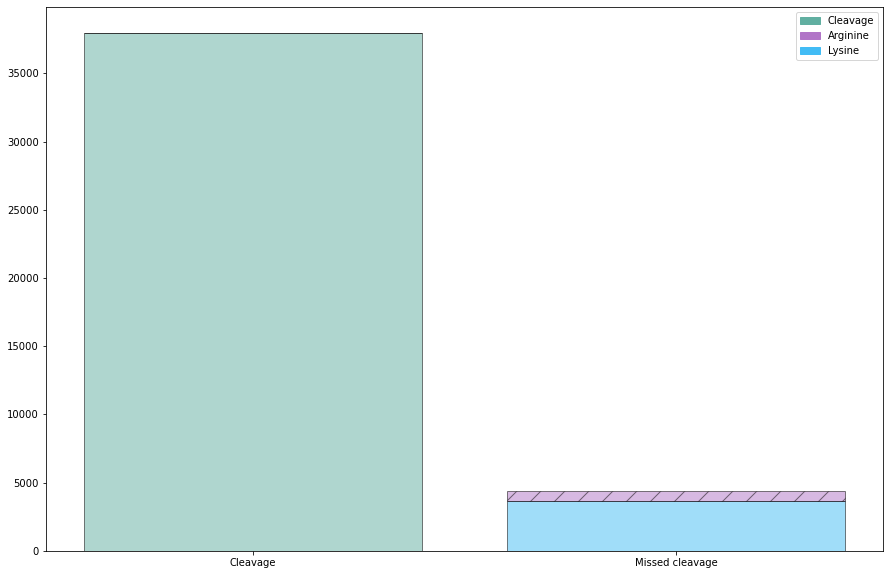

In [24]:
import matplotlib.patches as mpatches

x= ['Cleavage', 'Missed cleavage']
y= [len(Cleavage), 3685]
y1= [1, 719]
plt.figure(figsize=(15, 10))
plt.bar(x, y, color=["#61afa1",'#42bcf5'], width=0.8, alpha=0.5, edgecolor='black', linewidth=1)
plt.bar(x, y1, color= "#b175c7", width=0.8, alpha=0.5, bottom=y, hatch='/', edgecolor='black', linewidth=1)

Cleavage1 = mpatches.Patch(color='#61afa1', label='Cleavage')
Lysine = mpatches.Patch(color='#b175c7', label='Arginine')
Arginine = mpatches.Patch(color='#42bcf5', label='Lysine')


plt.legend(handles= [Cleavage1, Lysine, Arginine])
plt.show()

In [25]:
df_miss_cleavage['Last_AA'].value_counts()

K    3659
R     719
Name: Last_AA, dtype: int64

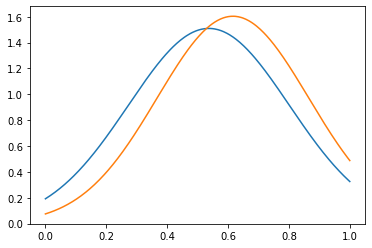

In [26]:
hmean = np.mean(h)
kmean = np.mean(k)

hstd = np.std(h)
kstf= np.std(k)

pdf = stats.norm.pdf(h, hmean, hstd)
pdf1 = stats.norm.pdf(k, kmean, kstf)

plt.plot(h, pdf) 
plt.plot(k, pdf1)

plt.show()

In [27]:
from scipy.stats import ttest_ind

df1 = df[df['relative ASA'] != '']



# cat1 = df1[df1['Cleavage']==0]
# cat2 = df1[df1['Cleavage']==1]


ttest_ind(Cleavage, Miss_cleavage)

Ttest_indResult(statistic=-18.866500381932223, pvalue=4.545478339445599e-79)

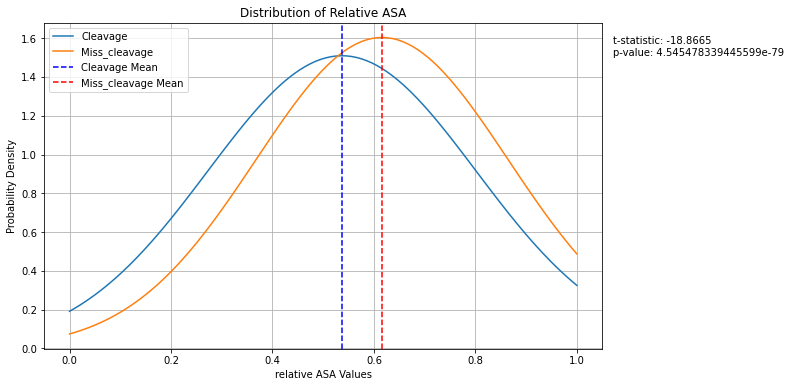

In [28]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import t, ttest_ind

# Perform independent t-test
t_statistic, p_value = ttest_ind(Cleavage, Miss_cleavage)

# Generate probability distribution for each group
x = np.linspace(min(min(Cleavage), min(Miss_cleavage)), max(max(Cleavage), max(Miss_cleavage)), 100)
pdf1 = t.pdf(x, df=len(Cleavage)-1, loc=np.mean(Cleavage), scale=np.std(Cleavage))
pdf2 = t.pdf(x, df=len(Miss_cleavage)-1, loc=np.mean(Miss_cleavage), scale=np.std(Miss_cleavage))

# Increase the size of the plot
plt.figure(figsize=(10, 6))

# Plot probability distribution graphs
plt.plot(x, pdf1, label='Cleavage')
plt.plot(x, pdf2, label='Miss_cleavage')


# Add mean thresholds
plt.axvline(np.mean(Cleavage), color='blue', linestyle='--', label='Cleavage Mean')
plt.axvline(np.mean(Miss_cleavage), color='red', linestyle='--', label='Miss_cleavage Mean')

# Set the y-limits to include the full gradient
#plt.ylim([0, max(max(pdf1), max(pdf2)) * 1.1])  # Adjust the multiplier (1.1) as needed

#Adding lables
plt.xlabel('relative ASA Values')
plt.ylabel('Probability Density')
plt.title('Distribution of Relative ASA')
plt.legend()
plt.grid(True)

# Display t-test result
plt.text(1.02, 0.9, f"t-statistic: {t_statistic:.4f}\np-value: {p_value}", transform=plt.gca().transAxes)

# Show the plot
plt.show()


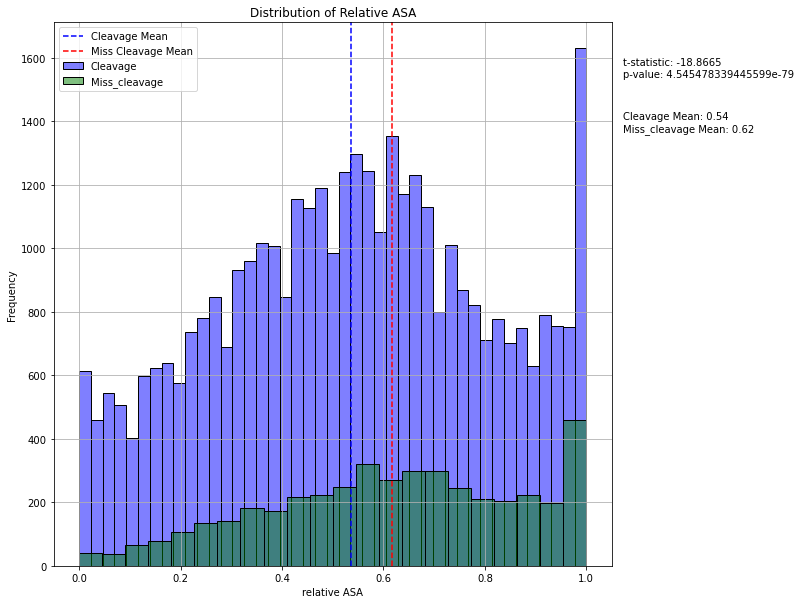

In [29]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import t, ttest_ind
import seaborn as sns

# Assuming you have already defined 'Cleavage' and 'Miss_cleavage' arrays

# Perform independent t-test
t_statistic, p_value = ttest_ind(Cleavage, Miss_cleavage)

# Generate probability distribution for each group
x = np.linspace(min(min(Cleavage), min(Miss_cleavage)), max(max(Cleavage), max(Miss_cleavage)), 100)
pdf1 = t.pdf(x, df=len(Cleavage)-1, loc=np.mean(Cleavage), scale=np.std(Cleavage))
pdf2 = t.pdf(x, df=len(Miss_cleavage)-1, loc=np.mean(Miss_cleavage), scale=np.std(Miss_cleavage))

# Increase the size of the plot
plt.figure(figsize=(10, 10))

# Plot probability density curves
#plt.plot(x, pdf1, color='blue', linestyle='-', label='Cleavage')plt.plot(x, pdf2, color='red', linestyle='-', label='Miss_cleavage')

# Overlay histograms or KDE plots
sns.histplot(Cleavage, color='blue', alpha=0.5, label='Cleavage')
sns.histplot(Miss_cleavage, color='green', alpha=0.5, label='Miss_cleavage')

# Add mean thresholds
plt.axvline(np.mean(Cleavage), color='blue', linestyle='--', label='Cleavage Mean')
plt.axvline(np.mean(Miss_cleavage), color='red', linestyle='--', label='Miss Cleavage Mean')

# Adding labels
plt.xlabel('relative ASA')
plt.ylabel('Frequency')
plt.title('Distribution of Relative ASA')
plt.legend()
plt.grid(True)

# Display t-test result and additional statistics
plt.text(1.02, 0.9, f"t-statistic: {t_statistic:.4f}\np-value: {p_value}", transform=plt.gca().transAxes)
plt.text(1.02, 0.8, f"Cleavage Mean: {np.mean(Cleavage):.2f}\nMiss_cleavage Mean: {np.mean(Miss_cleavage):.2f}", transform=plt.gca().transAxes)

# Show the plot
plt.show()

In [30]:
print(len(Cleavage))
print(len(Miss_cleavage))

37953
4378


In [31]:
def Residue_Depth_and_SASA(df):
    "Prints Residue Depth and SASA calculation to the dataframe"
    PA.get_residue_depth_name(df)
    PA.add_values(df)
    PA.generating_sasa_columns(df)
    return df

In [34]:
df=Residue_Depth_and_SASA(df)
df

4994
P0DP23
The file exists!
Q8N5C6
The file exists!
O60927
The file exists!
P46940
The file exists!
O94903
The file exists!
P49790
The file exists!
Q9BVK8
The file exists!
Q06481
The file exists!
P62312
The file exists!
O95208
The file exists!
Q9Y5B8
The file exists!
Q9H6S1
The file exists!
P25787
The file exists!
Q8NE71
The file exists!
O75477
The file exists!
Q9Y2G8
The file exists!
Q05639
The file exists!
O14495
The file exists!
O75170
The file exists!
P49902
The file exists!
Q13405
The file exists!
Q8NEY8
The file exists!
Q13247
The file exists!
Q8N3V7
The file exists!
Q7Z2T5
The file exists!
P43699
The file exists!
Q16531
The file exists!
P19367
The file exists!
P05362
The file exists!
P22059
The file exists!
Q15072
The file exists!
P08236
The file exists!
Q13509
The file exists!
Q9NUT2
The file exists!
Q8WZA0
The file exists!
Q9BU61
The file exists!
P23634
The file exists!
Q7Z589
The file exists!
Q15628
The file exists!
Q9H9P8
The file exists!
Q00796
The file exists!
P30260
The 

,Sequence,ProteinID,Modifications,start,end,cleavage_sites,Last_AA,LastAA_position,Cleavage,secondary_structure,...,2 Oxidation (M),3 Oxidation (M),Acetyl (Protein N-term),"Acetyl (Protein N-term),2 Oxidation (M)","Acetyl (Protein N-term),Oxidation (M)",Oxidation (M),Unmodified,res_depth,ca_depth,SASA
0,AAAAAAAATMALAAPSSPTPESPTMLTK,Q9NQS7,Unmodified,127,154,AAAAAAAATMALAAPSSPTPESPTMLTK,K,154,0,-,...,0,0,0,0,0,0,1,1.870620,1.999511,193.71
1,AAAAAAAGDSDSWDADAFSVEDPVR,O75822,Acetyl (Protein N-term),2,26,AAAAAAAGDSDSWDADAFSVEDPVR,R,26,0,-,...,0,0,1,0,0,0,0,1.806878,1.999812,231.46
2,AAAAAAAGDSDSWDADAFSVEDPVRK,O75822,Acetyl (Protein N-term),2,27,AAAAAAAGDSDSWDADAFSVEDPVR,R,26,1,-,...,0,0,1,0,0,0,0,1.806878,1.999812,231.46
3,AAAAAAAGDSDSWDADAFSVEDPVRK,O75822,Acetyl (Protein N-term),2,27,K,K,27,0,-,...,0,0,1,0,0,0,0,1.916649,1.999362,184.27
4,AAAAAAALQAK,P36578,Unmodified,354,364,AAAAAAALQAK,K,364,0,H,...,0,0,0,0,0,0,1,1.903494,1.999405,135.46
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44452,YYTEFPTVLDITAEDPSK,O14929,Unmodified,263,280,YYTEFPTVLDITAEDPSK,K,280,0,H,...,0,0,0,0,0,0,1,1.890864,1.999755,139.24
44453,YYTGNYDQYVK,Q9UG63,Unmodified,305,315,YYTGNYDQYVK,K,315,0,H,...,0,0,0,0,0,0,1,1.977119,1.999524,130.40
44454,YYTLEEIQK,P00167,Unmodified,11,19,YYTLEEIQK,K,19,0,H,...,0,0,0,0,0,0,1,1.920681,1.999527,127.21
44455,YYTLFGR,P07814,Unmodified,1504,1510,YYTLFGR,R,1510,0,-,...,0,0,0,0,0,0,1,3.268642,3.966887,23.47


In [35]:
df_sasa= df

In [36]:
df_sasa.to_csv('sasa_dataframe1.csv') #Save the dataframe to a csv file

In [37]:
df = pd.read_csv('sasa_dataframe1.csv')
df

,Unnamed: 0,Sequence,ProteinID,Modifications,start,end,cleavage_sites,Last_AA,LastAA_position,Cleavage,...,2 Oxidation (M),3 Oxidation (M),Acetyl (Protein N-term),"Acetyl (Protein N-term),2 Oxidation (M)","Acetyl (Protein N-term),Oxidation (M)",Oxidation (M),Unmodified,res_depth,ca_depth,SASA
0,0,AAAAAAAATMALAAPSSPTPESPTMLTK,Q9NQS7,Unmodified,127,154,AAAAAAAATMALAAPSSPTPESPTMLTK,K,154,0,...,0,0,0,0,0,0,1,1.870620,1.999511,193.71
1,1,AAAAAAAGDSDSWDADAFSVEDPVR,O75822,Acetyl (Protein N-term),2,26,AAAAAAAGDSDSWDADAFSVEDPVR,R,26,0,...,0,0,1,0,0,0,0,1.806878,1.999812,231.46
2,2,AAAAAAAGDSDSWDADAFSVEDPVRK,O75822,Acetyl (Protein N-term),2,27,AAAAAAAGDSDSWDADAFSVEDPVR,R,26,1,...,0,0,1,0,0,0,0,1.806878,1.999812,231.46
3,3,AAAAAAAGDSDSWDADAFSVEDPVRK,O75822,Acetyl (Protein N-term),2,27,K,K,27,0,...,0,0,1,0,0,0,0,1.916649,1.999362,184.27
4,4,AAAAAAALQAK,P36578,Unmodified,354,364,AAAAAAALQAK,K,364,0,...,0,0,0,0,0,0,1,1.903494,1.999405,135.46
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42326,44452,YYTEFPTVLDITAEDPSK,O14929,Unmodified,263,280,YYTEFPTVLDITAEDPSK,K,280,0,...,0,0,0,0,0,0,1,1.890864,1.999755,139.24
42327,44453,YYTGNYDQYVK,Q9UG63,Unmodified,305,315,YYTGNYDQYVK,K,315,0,...,0,0,0,0,0,0,1,1.977119,1.999524,130.40
42328,44454,YYTLEEIQK,P00167,Unmodified,11,19,YYTLEEIQK,K,19,0,...,0,0,0,0,0,0,1,1.920681,1.999527,127.21
42329,44455,YYTLFGR,P07814,Unmodified,1504,1510,YYTLFGR,R,1510,0,...,0,0,0,0,0,0,1,3.268642,3.966887,23.47


In [38]:
df_cleavage_res_depth= df.loc[df['Cleavage'] == 0]
df_miss_cleavage_res_depth= df.loc[df['Cleavage'] == 1]

In [39]:
df_cleavage_res_depth = df_cleavage_res_depth[df_cleavage_res_depth['res_depth'] != '']
df_miss_cleavage_res_depth = df_miss_cleavage_res_depth[df_miss_cleavage_res_depth['res_depth'] != '']

In [40]:
res_depth_Cleavage= []
for a in df_cleavage_res_depth['res_depth']:
    res_depth_Cleavage.append(a)


b= sorted(res_depth_Cleavage)

res_depth_Miss_cleavage= []
for c in df_miss_cleavage_res_depth['res_depth']:
    res_depth_Miss_cleavage.append(c)


d= sorted(res_depth_Miss_cleavage)

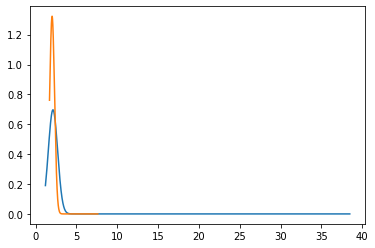

In [41]:
bmean = np.mean(b)
dmean = np.mean(d)

bstd = np.std(b)
dstf= np.std(d)

bpdf = stats.norm.pdf(b, bmean, bstd)
dpdf1 = stats.norm.pdf(d, dmean, dstf)

plt.plot(b, bpdf) 
plt.plot(d, dpdf1)

plt.show()

In [42]:
from scipy.stats import ttest_ind

df1 = df[df['res_depth'] != '']



res_depth_cat1 = df1[df1['Cleavage']==0]
res_depth_cat2 = df1[df1['Cleavage']==1]


ttest_ind(res_depth_Cleavage, res_depth_Miss_cleavage)

Ttest_indResult(statistic=12.201304273253974, pvalue=3.491662313247532e-34)

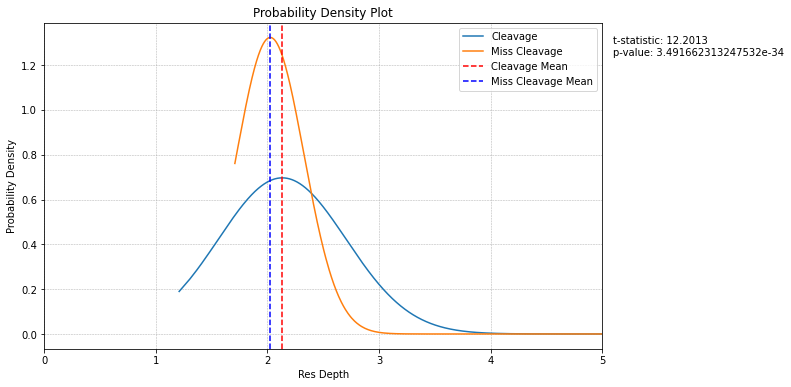

In [43]:
# Perform independent t-test
t_statistic, p_value = ttest_ind(res_depth_Cleavage, res_depth_Miss_cleavage)

# Create lists from dataframes
res_depth_Cleavage = df_cleavage_res_depth['res_depth'].tolist()
res_depth_Miss_cleavage = df_miss_cleavage_res_depth['res_depth'].tolist()

# Sort the lists
res_depth_Cleavage.sort()
res_depth_Miss_cleavage.sort()

# Calculate mean and standard deviation
bmean = np.mean(res_depth_Cleavage)
dmean = np.mean(res_depth_Miss_cleavage)
bstd = np.std(res_depth_Cleavage)
dstf = np.std(res_depth_Miss_cleavage)

# Calculate probability density functions
bpdf = stats.norm.pdf(res_depth_Cleavage, bmean, bstd)
dpdf = stats.norm.pdf(res_depth_Miss_cleavage, dmean, dstf)

# Increase the size of the plot
plt.figure(figsize=(10, 6))

# Plot the probability density functions
plt.plot(res_depth_Cleavage, bpdf, label='Cleavage')
plt.plot(res_depth_Miss_cleavage, dpdf, label='Miss Cleavage')

# Add gridlines
plt.grid(True, linestyle='--', linewidth=0.5)

# Add thresholds
plt.axvline(bmean, color='r', linestyle='--', label='Cleavage Mean')
plt.axvline(dmean, color='b', linestyle='--', label='Miss Cleavage Mean')

# Add legend
plt.legend()

# Set axis labels and title
plt.xlabel('Res Depth')
plt.ylabel('Probability Density')
plt.title('Probability Density Plot')

# Set the limits of the x-axis
xmin = 0  # Set the lower limit of the x-axis
xmax = 5  # Set the upper limit of the x-axis
plt.xlim(xmin, xmax)

# Display t-test result
plt.text(1.02, 0.9, f"t-statistic: {t_statistic:.4f}\np-value: {p_value}", transform=plt.gca().transAxes)

# Show the plot
plt.show()


overflow encountered in power


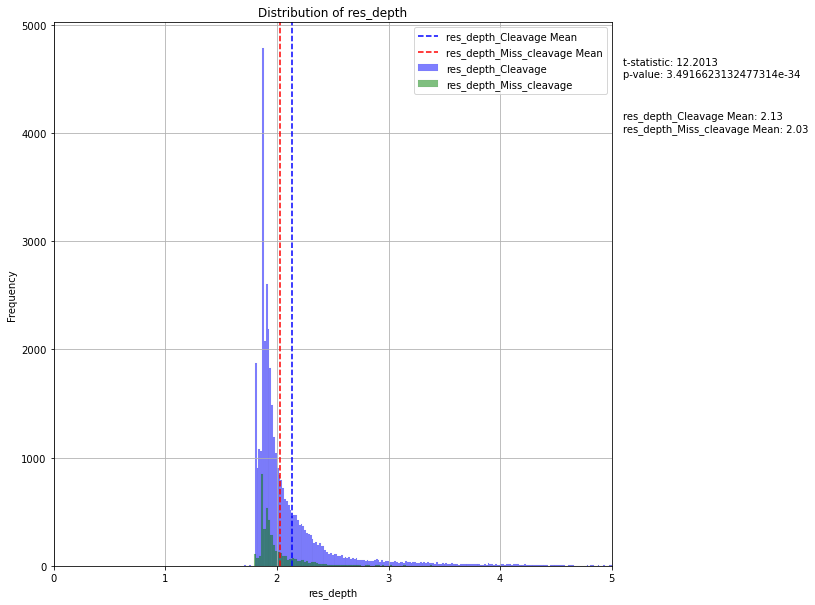

In [44]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import t, ttest_ind
import seaborn as sns

# Assuming you have already defined 'res_depth_Cleavage' and 'res_depth_Miss_cleavage' arrays

# Perform independent t-test
t_statistic, p_value = ttest_ind(res_depth_Cleavage, res_depth_Miss_cleavage)

# Generate probability distribution for each group
x = np.linspace(min(min(res_depth_Cleavage), min(res_depth_Miss_cleavage)), max(max(res_depth_Cleavage), max(res_depth_Miss_cleavage)), 100)
pdf1 = t.pdf(x, df=len(res_depth_Cleavage)-1, loc=np.mean(res_depth_Cleavage), scale=np.std(res_depth_Cleavage))
pdf2 = t.pdf(x, df=len(res_depth_Miss_cleavage)-1, loc=np.mean(res_depth_Miss_cleavage), scale=np.std(res_depth_Miss_cleavage))

# Increase the size of the plot
plt.figure(figsize=(10, 10))

# Plot probability density curves
#plt.plot(x, pdf1, color='blue', linestyle='-', label='Cleavage')plt.plot(x, pdf2, color='red', linestyle='-', label='Miss_cleavage')

# Overlay histograms or KDE plots
sns.histplot(res_depth_Cleavage, color='blue', alpha=0.5, label='res_depth_Cleavage')
sns.histplot(res_depth_Miss_cleavage, color='green', alpha=0.5, label='res_depth_Miss_cleavage')

# Add mean thresholds
plt.axvline(np.mean(res_depth_Cleavage), color='blue', linestyle='--', label='res_depth_Cleavage Mean')
plt.axvline(np.mean(res_depth_Miss_cleavage), color='red', linestyle='--', label='res_depth_Miss_cleavage Mean')

# Adding labels
plt.xlabel('res_depth')
plt.ylabel('Frequency')
plt.title('Distribution of res_depth')
plt.legend()
plt.grid(True)

# Set the limits of the x-axis
xmin = 0  # Set the lower limit of the x-axis
xmax = 5  # Set the upper limit of the x-axis
plt.xlim(xmin, xmax)

# Display t-test result and additional statistics
plt.text(1.02, 0.9, f"t-statistic: {t_statistic:.4f}\np-value: {p_value}", transform=plt.gca().transAxes)
plt.text(1.02, 0.8, f"res_depth_Cleavage Mean: {np.mean(res_depth_Cleavage):.2f}\nres_depth_Miss_cleavage Mean: {np.mean(res_depth_Miss_cleavage):.2f}", transform=plt.gca().transAxes)

# Show the plot
plt.show()

In [45]:
df_cleavage_ca_depth= df.loc[df['Cleavage'] == 0]
df_miss_cleavage_ca_depth= df.loc[df['Cleavage'] == 1]

In [46]:
df_cleavage_ca_depth = df_cleavage_ca_depth[df_cleavage_ca_depth['ca_depth'] != '']
df_miss_cleavage_ca_depth = df_miss_cleavage_ca_depth[df_miss_cleavage_ca_depth['ca_depth'] != '']

In [47]:
ca_depth_Cleavage= []
for e in df_cleavage_ca_depth['ca_depth']:
    ca_depth_Cleavage.append(e)


f= sorted(ca_depth_Cleavage)

ca_depth_Miss_cleavage= []
for g in df_miss_cleavage_ca_depth['ca_depth']:
    ca_depth_Miss_cleavage.append(g)


I= sorted(ca_depth_Miss_cleavage)

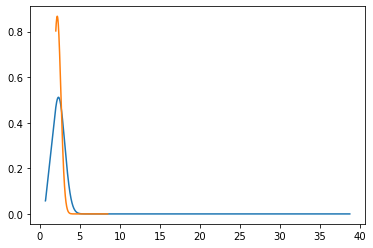

In [48]:
fmean = np.mean(f)
Imean = np.mean(I)

fstd = np.std(f)
Istf= np.std(I)

fpdf = stats.norm.pdf(f, fmean, fstd)
Ipdf1 = stats.norm.pdf(I, Imean, Istf)

plt.plot(f, fpdf) 
plt.plot(I, Ipdf1)

plt.show()

In [49]:
from scipy.stats import ttest_ind

df1 = df[df['res_depth'] != '']



ca_depth_cat1 = df1[df1['Cleavage']==0]
ca_depth_cat2 = df1[df1['Cleavage']==1]


ttest_ind(ca_depth_Cleavage, ca_depth_Miss_cleavage)

Ttest_indResult(statistic=12.623521515064326, pvalue=1.822769779886361e-36)

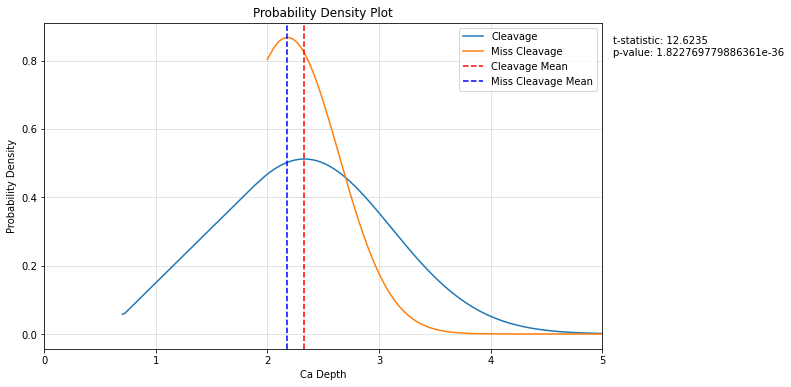

In [50]:
# Perform independent t-test
t_statistic, p_value = ttest_ind(ca_depth_Cleavage, ca_depth_Miss_cleavage)

# Create lists from dataframes
ca_depth_Cleavage = df_cleavage_ca_depth['ca_depth'].tolist()
ca_depth_Miss_cleavage = df_miss_cleavage_ca_depth['ca_depth'].tolist()

# Sort the lists
ca_depth_Cleavage.sort()
ca_depth_Miss_cleavage.sort()


# Calculate probability density functions
bpdf = stats.norm.pdf(ca_depth_Cleavage, fmean, fstd)
dpdf = stats.norm.pdf(ca_depth_Miss_cleavage, Imean, Istf)

# Increase the size of the plot
plt.figure(figsize=(10, 6))

# Plot the probability density functions
plt.plot(ca_depth_Cleavage, fpdf, label='Cleavage')
plt.plot(ca_depth_Miss_cleavage, Ipdf1, label='Miss Cleavage')

# Add gridlines
plt.grid(True, linestyle='--', linewidth=0.5)

# Add thresholds
plt.axvline(fmean, color='r', linestyle='--', label='Cleavage Mean')
plt.axvline(Imean, color='b', linestyle='--', label='Miss Cleavage Mean')

# Add legend
plt.legend()

# Set axis labels and title
plt.xlabel('Ca Depth')
plt.ylabel('Probability Density')
plt.title('Probability Density Plot')

# Set the limits of the x-axis
xmin = 0  # Set the lower limit of the x-axis
xmax = 5  # Set the upper limit of the x-axis
plt.xlim(xmin, xmax)


# Display t-test result
plt.text(1.02, 0.9, f"t-statistic: {t_statistic:.4f}\np-value: {p_value}", transform=plt.gca().transAxes)

# Show the plot
plt.show()

overflow encountered in power


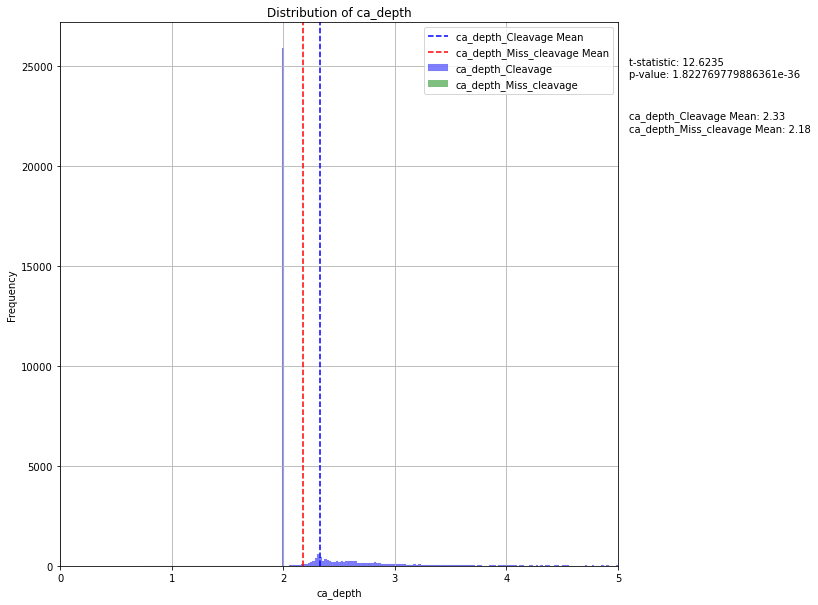

In [51]:

# Perform independent t-test
t_statistic, p_value = ttest_ind(ca_depth_Cleavage, ca_depth_Miss_cleavage)

# Generate probability distribution for each group
x = np.linspace(min(min(ca_depth_Cleavage), min(ca_depth_Miss_cleavage)), max(max(ca_depth_Cleavage), max(ca_depth_Miss_cleavage)), 100)
pdf1 = t.pdf(x, df=len(ca_depth_Cleavage)-1, loc=np.mean(ca_depth_Cleavage), scale=np.std(ca_depth_Cleavage))
pdf2 = t.pdf(x, df=len(ca_depth_Miss_cleavage)-1, loc=np.mean(ca_depth_Miss_cleavage), scale=np.std(ca_depth_Miss_cleavage))

# Increase the size of the plot
plt.figure(figsize=(10, 10))

# Plot probability density curves
#plt.plot(x, pdf1, color='blue', linestyle='-', label='Cleavage')plt.plot(x, pdf2, color='red', linestyle='-', label='Miss_cleavage')

# Overlay histograms or KDE plots
sns.histplot(ca_depth_Cleavage, color='blue', alpha=0.5, label='ca_depth_Cleavage')
sns.histplot(ca_depth_Miss_cleavage, color='green', alpha=0.5, label='ca_depth_Miss_cleavage')

# Add mean thresholds
plt.axvline(np.mean(ca_depth_Cleavage), color='blue', linestyle='--', label='ca_depth_Cleavage Mean')
plt.axvline(np.mean(ca_depth_Miss_cleavage), color='red', linestyle='--', label='ca_depth_Miss_cleavage Mean')

# Adding labels
plt.xlabel('ca_depth')
plt.ylabel('Frequency')
plt.title('Distribution of ca_depth')
plt.legend()
plt.grid(True)

# Set the limits of the x-axis
xmin = 0  # Set the lower limit of the x-axis
xmax = 5  # Set the upper limit of the x-axis
plt.xlim(xmin, xmax)


# Display t-test result and additional statistics
plt.text(1.02, 0.9, f"t-statistic: {t_statistic:.4f}\np-value: {p_value}", transform=plt.gca().transAxes)
plt.text(1.02, 0.8, f"ca_depth_Cleavage Mean: {np.mean(ca_depth_Cleavage):.2f}\nca_depth_Miss_cleavage Mean: {np.mean(ca_depth_Miss_cleavage):.2f}", transform=plt.gca().transAxes)

# Show the plot
plt.show()

In [52]:
df_cleavage_SASA= df.loc[df['Cleavage'] == 0]
df_miss_cleavage_SASA= df.loc[df['Cleavage'] == 1]

In [53]:
df_cleavage_SASA = df_cleavage_SASA[df_cleavage_SASA['SASA'] != '']
df_miss_cleavage_SASA = df_miss_cleavage_SASA[df_miss_cleavage_SASA['SASA'] != '']

In [54]:
SASA_Cleavage= []
for j in df_cleavage_SASA['SASA']:
    SASA_Cleavage.append(j)


l= sorted(SASA_Cleavage)

SASA_Miss_cleavage= []
for m in df_miss_cleavage_SASA['SASA']:
    SASA_Miss_cleavage.append(m)


n= sorted(SASA_Miss_cleavage)

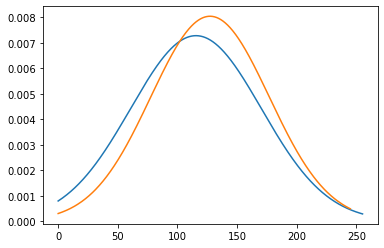

In [55]:
lmean = np.mean(l)
nmean = np.mean(n)

lstd = np.std(l)
nstf= np.std(n)

lpdf = stats.norm.pdf(l, lmean, lstd)
npdf1 = stats.norm.pdf(n, nmean, nstf)

plt.plot(l, lpdf) 
plt.plot(n, npdf1)

plt.show()

In [56]:
from scipy.stats import ttest_ind

df1 = df[df['res_depth'] != '']



SASA_cat1 = df1[df1['Cleavage']==0]
SASA_cat2 = df1[df1['Cleavage']==1]


ttest_ind(SASA_Cleavage, SASA_Miss_cleavage)

Ttest_indResult(statistic=-13.591234826045346, pvalue=5.530617504370316e-42)

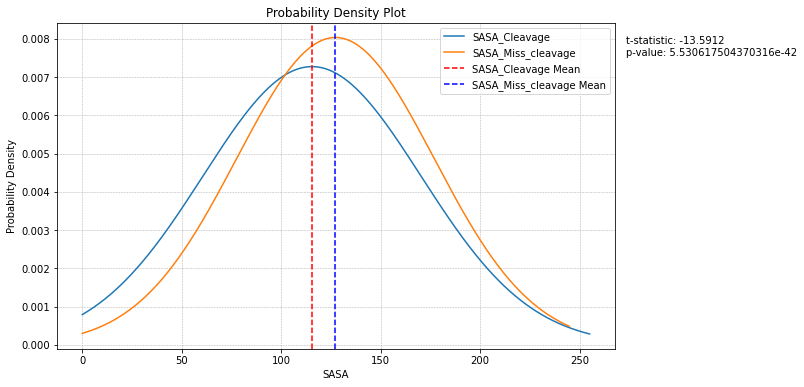

In [57]:
# Perform independent t-test
t_statistic, p_value = ttest_ind(SASA_Cleavage, SASA_Miss_cleavage)

# Create lists from dataframes
SASA_Cleavage = df_cleavage_SASA['SASA'].tolist()
SASA_Miss_cleavage = df_miss_cleavage_SASA['SASA'].tolist()

# Sort the lists
SASA_Cleavage.sort()
SASA_Miss_cleavage.sort()


# Calculate probability density functions
bpdf = stats.norm.pdf(SASA_Cleavage, lmean, lstd)
dpdf = stats.norm.pdf(SASA_Miss_cleavage, nmean, nstf)

# Increase the size of the plot
plt.figure(figsize=(10, 6))

# Plot the probability density functions
plt.plot(SASA_Cleavage, lpdf, label='SASA_Cleavage')
plt.plot(SASA_Miss_cleavage, npdf1, label='SASA_Miss_cleavage')

# Add gridlines
plt.grid(True, linestyle='--', linewidth=0.5)

# Add thresholds
plt.axvline(lmean, color='r', linestyle='--', label='SASA_Cleavage Mean')
plt.axvline(nmean, color='b', linestyle='--', label='SASA_Miss_cleavage Mean')

# Add legend
plt.legend()

# Set axis labels and title
plt.xlabel('SASA')
plt.ylabel('Probability Density')
plt.title('Probability Density Plot')

# Display t-test result
plt.text(1.02, 0.9, f"t-statistic: {t_statistic:.4f}\np-value: {p_value}", transform=plt.gca().transAxes)

# Show the plot
plt.show()

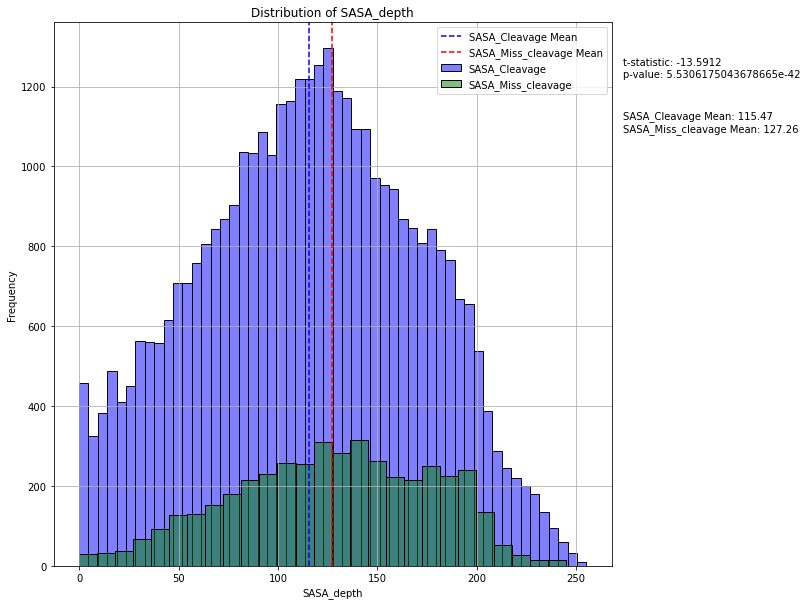

In [58]:
# Perform independent t-test
t_statistic, p_value = ttest_ind(SASA_Cleavage, SASA_Miss_cleavage)

# Generate probability distribution for each group
x = np.linspace(min(min(SASA_Cleavage), min(SASA_Miss_cleavage)), max(max(SASA_Cleavage), max(SASA_Miss_cleavage)), 100)
pdf1 = t.pdf(x, df=len(SASA_Cleavage)-1, loc=np.mean(SASA_Cleavage), scale=np.std(SASA_Cleavage))
pdf2 = t.pdf(x, df=len(SASA_Miss_cleavage)-1, loc=np.mean(SASA_Miss_cleavage), scale=np.std(SASA_Miss_cleavage))

# Increase the size of the plot
plt.figure(figsize=(10, 10))

# Plot probability density curves
#plt.plot(x, pdf1, color='blue', linestyle='-', label='Cleavage')plt.plot(x, pdf2, color='red', linestyle='-', label='Miss_cleavage')

# Overlay histograms or KDE plots
sns.histplot(SASA_Cleavage, color='blue', alpha=0.5, label='SASA_Cleavage')
sns.histplot(SASA_Miss_cleavage, color='green', alpha=0.5, label='SASA_Miss_cleavage')

# Add mean thresholds
plt.axvline(np.mean(SASA_Cleavage), color='blue', linestyle='--', label='SASA_Cleavage Mean')
plt.axvline(np.mean(SASA_Miss_cleavage), color='red', linestyle='--', label='SASA_Miss_cleavage Mean')

# Adding labels
plt.xlabel('SASA_depth')
plt.ylabel('Frequency')
plt.title('Distribution of SASA_depth')
plt.legend()
plt.grid(True)

# Display t-test result and additional statistics
plt.text(1.02, 0.9, f"t-statistic: {t_statistic:.4f}\np-value: {p_value}", transform=plt.gca().transAxes)
plt.text(1.02, 0.8, f"SASA_Cleavage Mean: {np.mean(SASA_Cleavage):.2f}\nSASA_Miss_cleavage Mean: {np.mean(SASA_Miss_cleavage):.2f}", transform=plt.gca().transAxes)

# Show the plot
plt.show()

In [59]:
#change cleavage values from 0 to 1 if the peptide has a duplicate that has cleavage value1
df['Cleavage']= df.duplicated(subset=[ 'ProteinID','cleavage_sites', 'LastAA_position'], keep=False) #keep=False to drop duplicates
df['Cleavage']= df['Cleavage'].astype(int) #convert to int

In [60]:

def check_duplicates(df, seq, elem_id, res_depth, Cleavage):
    
    different_groups = True if df[(df.cleavage_sites == seq) & (df.res_depth == res_depth) & (df.ProteinID == elem_id)]['Cleavage'].nunique() > 1 else False 
    sequence_dupls = True if len(df[df.cleavage_sites == seq]) > 1 else False
    id_dupls = True if len(df[df.ProteinID == elem_id]) > 1 else False
    res_depth_dupls = True if len(df[df.res_depth == res_depth]) > 1 else False
    
    if sequence_dupls and id_dupls and res_depth_dupls and different_groups:
        return 1 
    else:
        return Cleavage


df['Cleavage'] = df.apply(lambda row: check_duplicates(df, row.cleavage_sites, row.ProteinID, row.res_depth,row.Cleavage), axis=1)


# Machine learning #

In [61]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
import seaborn as sn
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

In [62]:
print(df.columns)

Index(['Unnamed: 0', 'Sequence', 'ProteinID', 'Modifications', 'start', 'end',
       'cleavage_sites', 'Last_AA', 'LastAA_position', 'Cleavage',
       'secondary_structure', 'relative ASA', 'phi', 'psi', 'NH01R', 'NH01E',
       'ONH1', 'ONHE', 'NH2R', 'NO2E', 'ONH2R', 'ONH2E', '-', 'B', 'E', 'G',
       'H', 'I', 'S', 'T', '2 Oxidation (M)', '3 Oxidation (M)',
       'Acetyl (Protein N-term)', 'Acetyl (Protein N-term),2 Oxidation (M)',
       'Acetyl (Protein N-term),Oxidation (M)', 'Oxidation (M)', 'Unmodified',
       'res_depth', 'ca_depth', 'SASA'],
      dtype='object')


In [63]:
df_miss_cleavage= df.loc[df['Cleavage'] == 1]
len(df_miss_cleavage)

4552

In [64]:
df_cleavage= df.loc[df['Cleavage'] == 0]
df_cleavage= df_cleavage.sample(n=4552)
df_test= pd.concat([df_miss_cleavage, df_cleavage])

In [65]:
df_test.to_csv('df_test2.csv', index=False)

In [66]:
df_test['Cleavage'].value_counts()

1    4552
0    4552
Name: Cleavage, dtype: int64

In [67]:
x = df_test[['relative ASA', 'phi', 'psi', 'NH01R', 'NH01E',
       'ONH1', 'ONHE', 'NH2R', 'NO2E', 'ONH2R', 'ONH2E', '-', 'B', 'E', 'G',
       'H', 'I', 'S', 'T', '2 Oxidation (M)', '3 Oxidation (M)',
       'Acetyl (Protein N-term)', 'Acetyl (Protein N-term),2 Oxidation (M)',
       'Acetyl (Protein N-term),Oxidation (M)', 'Oxidation (M)', 'Unmodified', 'res_depth', 'ca_depth', 'SASA']]
       
y = df_test['Cleavage']

In [68]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Standardize the data
scaler = StandardScaler()
x_scaled = scaler.fit_transform(x)

# Reshape x array
x_reshaped = x_scaled.reshape(-1, len(x.columns))

# Perform PCA
pca = PCA()
x_pca = pca.fit_transform(x_reshaped)

# Variance explained by each principal component
explained_variance = pca.explained_variance_ratio_

# Print the variance explained by each principal component
for i, var in enumerate(explained_variance):
    print(f"Principal Component {i+1}: {var:.4f}")

# You can also access the principal components themselves
principal_components = pca.components_

# Accessing the first two principal components (for visualization purposes, if desired)
pc1 = x_pca[:, 0]
pc2 = x_pca[:, 1]

Principal Component 1: 0.1637
Principal Component 2: 0.0892
Principal Component 3: 0.0707
Principal Component 4: 0.0627
Principal Component 5: 0.0509
Principal Component 6: 0.0472
Principal Component 7: 0.0397
Principal Component 8: 0.0380
Principal Component 9: 0.0371
Principal Component 10: 0.0364
Principal Component 11: 0.0358
Principal Component 12: 0.0357
Principal Component 13: 0.0357
Principal Component 14: 0.0354
Principal Component 15: 0.0349
Principal Component 16: 0.0284
Principal Component 17: 0.0277
Principal Component 18: 0.0245
Principal Component 19: 0.0240
Principal Component 20: 0.0204
Principal Component 21: 0.0193
Principal Component 22: 0.0188
Principal Component 23: 0.0148
Principal Component 24: 0.0051
Principal Component 25: 0.0030
Principal Component 26: 0.0008
Principal Component 27: 0.0000
Principal Component 28: 0.0000
Principal Component 29: 0.0000


0.9999999999999999


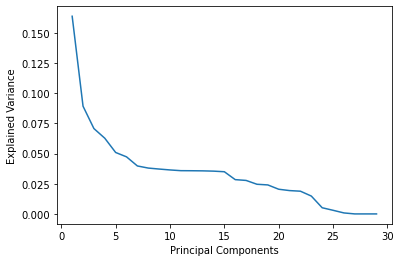

In [69]:
print(pca.explained_variance_ratio_.sum())
plt.plot(range(1,30),pca.explained_variance_ratio_)
plt.xlabel("Principal Components")
plt.ylabel("Explained Variance")
plt.show()
# observations:
#each PC captures less than the first, as expected.
#first 2 PCs capture 

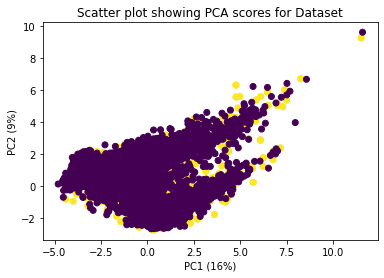

In [70]:
import matplotlib.pyplot as plt

# Replace sample_colours with your numerical variable for color mapping
sample_colours = df_test['Cleavage'].values

# Plotting the scatter plot using the first two principal components
plt.scatter(pc1, pc2, c=sample_colours, cmap='viridis')
plt.xlabel('PC1 (' + str(round(explained_variance[0] * 100)) + '%)')
plt.ylabel('PC2 (' + str(round(explained_variance[1] * 100)) + '%)')
plt.title('Scatter plot showing PCA scores for Dataset')

# Show the plot
plt.show()


In [71]:
len(df_test['Cleavage'])

9104

In [72]:
from sklearn.tree import plot_tree


X_train,X_test,y_train,y_test = train_test_split(x,y,test_size=0.25,random_state=42)

clf = RandomForestClassifier(n_estimators=1000)
clf.fit(X_train,y_train)
y_pred=clf.predict(X_test)

# Compute the confidence scores for the testing data
y_confidence = clf.predict_proba(X_test)
y_confidence = [probability[1] for probability in y_confidence]
y_confidence_formatted = ["{:.3f}".format(num) for num in y_confidence]

In [73]:
# from Bio.PDB.ResidueDepth import ResidueDepth
# from Bio.PDB.SASA import ShrakeRupley
# from sklearn.model_selection import train_test_split
# from sklearn.utils import resample
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.metrics import accuracy_score

# # Split the data into training and testing sets
# X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=42)

# # Define the random forest classifier
# clf = RandomForestClassifier(n_estimators=1000, random_state=42)

# # Define the number of bootstrap iterations
# n_iterations = 100

# # Define a list to store the accuracy scores for each iteration
# scores = []

# # Perform bootstrap validation
# for i in range(n_iterations):
#     # Generate a bootstrap sample from the training data
#     X_train_boot, y_train_boot = resample(X_train, y_train, random_state=i)

#     # Train the random forest classifier on the bootstrap sample
#     clf.fit(X_train_boot, y_train_boot)
    
#     # Predict the classes of the testing data
#     y_pred = clf.predict(X_test)
    
#     # Compute the accuracy score on the testing data
#     score = accuracy_score(y_test, y_pred)
    
#     # Store the accuracy score for this iteration
#     scores.append(score)

# # Calculate the mean and standard deviation of the accuracy scores
# mean_score = np.mean(scores)
# std_score = np.std(scores)

# # Print the results
# print("Bootstrap validation results:")
# print("Mean accuracy score:", mean_score)
# print("Standard deviation of accuracy scores:", std_score)


Accuracy:  0.8000878734622144


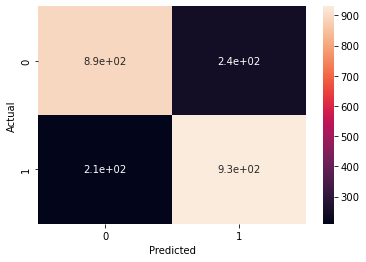

In [74]:
confusion_matrix = pd.crosstab(y_test, y_pred, rownames=['Actual'], colnames=['Predicted'])
sn.heatmap(confusion_matrix, annot=True)
print('Accuracy: ',metrics.accuracy_score(y_test, y_pred))
plt.show()

Accuracy: 0.8000878734622144


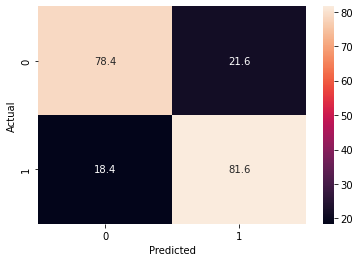

In [75]:
confusion_matrix = pd.crosstab(y_test, y_pred, rownames=['Actual'], colnames=['Predicted'])

# Calculate row-wise percentages
row_sums = confusion_matrix.sum(axis=1)
confusion_matrix_percent = confusion_matrix.div(row_sums, axis=0) * 100

# Display the confusion matrix with percentages
sn.heatmap(confusion_matrix_percent, annot=True, fmt=".1f")  # Use ".1f" to display one decimal place

print('Accuracy:', metrics.accuracy_score(y_test, y_pred))
plt.show()

In [77]:
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

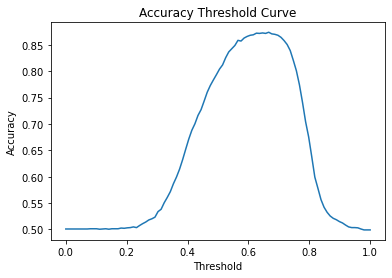

In [78]:
thresholds = np.linspace(0, 1, num=100)
accuracies = []
for threshold in thresholds:
    y_pred_threshold = (clf.predict_proba(X_test)[:, 1] >= threshold).astype(int)
    accuracy = accuracy_score(y_test, y_pred_threshold)
    accuracies.append(accuracy)

plt.plot(thresholds, accuracies)
plt.xlabel('Threshold')
plt.ylabel('Accuracy')
plt.title('Accuracy Threshold Curve')
plt.show()

In [79]:
# Compare predictions with truth values
ProteinIDs=df['ProteinID'].tolist()
data_frame=pd.DataFrame({'relative ASA':X_test['relative ASA'] ,'Prediction':y_pred,'Probability':y_confidence_formatted})
merged_df = pd.merge(data_frame, df, on='relative ASA')
merged_df = merged_df[['ProteinID', 'start', 'end', 'cleavage_sites', 'Cleavage', 'Prediction','Probability']]
print(merged_df)

       ProteinID  start  end            cleavage_sites  Cleavage  Prediction  \
0         P51970     27   41           AAAHHYGAQCDKPNK         0           0   
1         Q15418     57   66                ADPSHFELLK         0           0   
2         P05556    138  163                   DDLENVK         1           0   
3         Q6ZRP7    280  287                  AFFSSYLK         0           0   
4         P05556    651  657                       GEK         0           0   
...          ...    ...  ...                       ...       ...         ...   
360322    Q9UIA9     74   83                TNNPLPLEQR         0           0   
360323    P24666     42   59        VDSAATSGYEIGNPPDYR         0           0   
360324    Q9H0H0     29   43           VDVVCLASLSDPELR         0           0   
360325    Q7KZF4    415  438  VNVTVDYIRPASPATETVPAFSER         1           0   
360326    P14550     35   42                  YALSVGYR         0           0   

       Probability  
0            0.424

In [80]:
# select rows where the value in Prediction is equal to 1
df_ones = merged_df[merged_df['Prediction'] == 1]

# sort the resulting dataframe by the values in Probability in ascending order
df_ones_sorted = df_ones.sort_values('Probability', ascending=True)

# select the first row with the lowest Probability
result = df_ones_sorted.iloc[0]
threshold=result['Probability']
print(threshold)

0.501


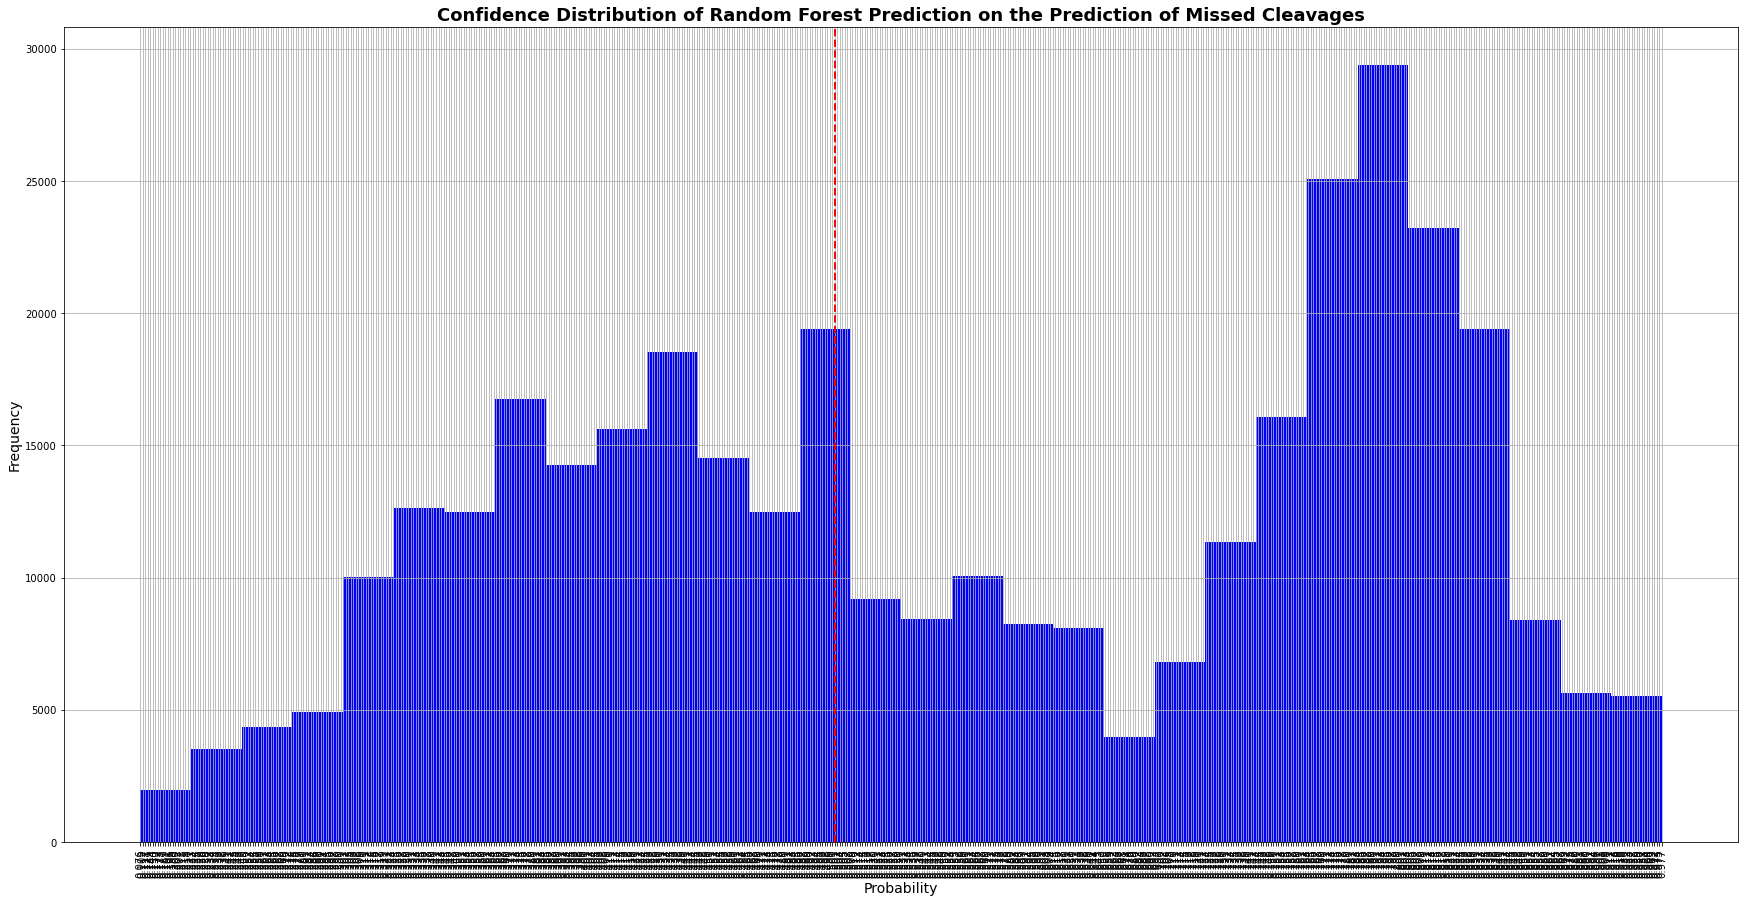

In [81]:
# Sort the Order_df dataframe by the 'end' column
Order_df = merged_df.sort_values('Probability')


# Create a figure and an axis object for the plot
fig, ax1 = plt.subplots(figsize=(30, 15))

# Add a histogram to the axis object
ax1.hist(Order_df['Probability'], bins=30, color='blue')
ax1.set_xlabel('Probability', fontsize=14)
ax1.set_ylabel('Frequency', fontsize=14)
plt.title('Confidence Distribution of Random Forest Prediction on the Prediction of Missed Cleavages', fontsize=18, fontweight='bold')

# Customize the appearance of the plot
ax1.set_ylim(0)  # Set the y-axis limits for the first axis

# Add a vertical line at the threshold value
#threshold = 0.5
ax1.axvline(threshold, color='red', linestyle='dashed', linewidth=2)

# rotate x-axis label
plt.xticks(rotation=90)

# Add grid
plt.grid(True)

# Display plot
plt.show()

In [82]:
# # Set the threshold value
# threshold = input('Input threshold:')

# # Filter the dataframe based on the threshold value
# filtered_df = merged_df[merged_df['Probability'] > threshold]

# # Print the filtered dataframe
# print(filtered_df)

In [83]:
import shap

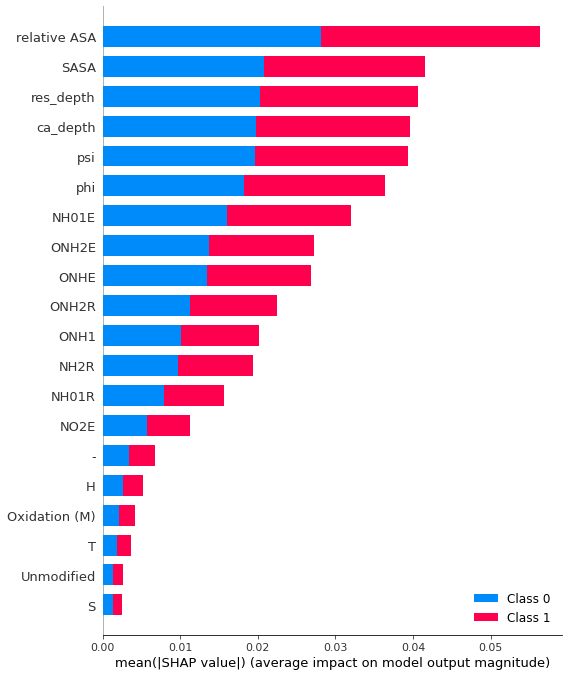

In [84]:
explainer = shap.TreeExplainer(clf)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test)
plt.show()

In [85]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.81      0.78      0.80      1136
           1       0.79      0.82      0.80      1140

    accuracy                           0.80      2276
   macro avg       0.80      0.80      0.80      2276
weighted avg       0.80      0.80      0.80      2276



# XG Boost #

In [86]:
print(df.columns)

Index(['Unnamed: 0', 'Sequence', 'ProteinID', 'Modifications', 'start', 'end',
       'cleavage_sites', 'Last_AA', 'LastAA_position', 'Cleavage',
       'secondary_structure', 'relative ASA', 'phi', 'psi', 'NH01R', 'NH01E',
       'ONH1', 'ONHE', 'NH2R', 'NO2E', 'ONH2R', 'ONH2E', '-', 'B', 'E', 'G',
       'H', 'I', 'S', 'T', '2 Oxidation (M)', '3 Oxidation (M)',
       'Acetyl (Protein N-term)', 'Acetyl (Protein N-term),2 Oxidation (M)',
       'Acetyl (Protein N-term),Oxidation (M)', 'Oxidation (M)', 'Unmodified',
       'res_depth', 'ca_depth', 'SASA'],
      dtype='object')


In [87]:
df_miss_cleavage= df.loc[df['Cleavage'] == 1]
len(df_miss_cleavage)

4552

In [88]:
df_cleavage= df.loc[df['Cleavage'] == 0]
df_cleavage= df_cleavage.sample(n=4552)
df_test= pd.concat([df_miss_cleavage, df_cleavage])

In [89]:
df_test.to_csv('df_xgboostPTEN.csv', index=False)

In [90]:
df_test['Cleavage'].value_counts()

1    4552
0    4552
Name: Cleavage, dtype: int64

In [91]:
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Step 1: Loading preprocessed  data

X = df_test[['relative ASA', 'phi', 'psi', 'NH01R', 'NH01E',
       'ONH1', 'ONHE', 'NH2R', 'NO2E', 'ONH2R', 'ONH2E', '-', 'B', 'E', 'G',
       'H', 'I', 'S', 'T', '2 Oxidation (M)', '3 Oxidation (M)',
       'Acetyl (Protein N-term)', 'Acetyl (Protein N-term),2 Oxidation (M)',
       'Acetyl (Protein N-term),Oxidation (M)', 'Oxidation (M)', 'Unmodified', 'res_depth', 'ca_depth', 'SASA']]  # Features
y = df_test['Cleavage']  # Target variable

# Step 2: Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Step 3: Define the XGBoost model
model = xgb.XGBClassifier(learning_rate=0.1, max_depth=3, n_estimators=1000)

# Step 4: Train the model
model.fit(X_train, y_train)

# Step 5: Evaluate the model
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.6423550087873462


Accuracy:  0.6423550087873462


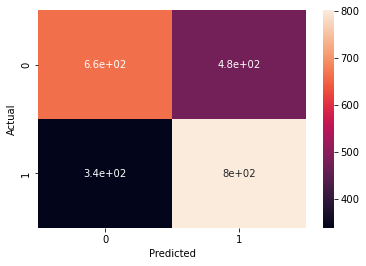

In [92]:
confusion_matrix = pd.crosstab(y_test, y_pred, rownames=['Actual'], colnames=['Predicted'])
sn.heatmap(confusion_matrix, annot=True)
print('Accuracy: ',metrics.accuracy_score(y_test, y_pred))
plt.show()

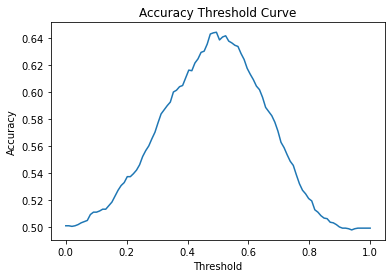

In [93]:
# Evaluate the best model on the test set
y_pred_prob = model.predict_proba(X_test)[:, 1]  # Predicted probabilities for the positive class

# Create the accuracy threshold curve
thresholds = np.linspace(0, 1, 100)  # Vary the threshold from 0 to 1
accuracies = []  # Store the accuracies for each threshold

for threshold in thresholds:
    y_pred_threshold = (y_pred_prob >= threshold).astype(int)  # Apply the threshold to the predicted probabilities
    accuracy = accuracy_score(y_test, y_pred_threshold)  # Compute accuracy
    accuracies.append(accuracy)

# Plot the accuracy threshold curve
plt.plot(thresholds, accuracies)
plt.xlabel('Threshold')
plt.ylabel('Accuracy')
plt.title('Accuracy Threshold Curve')
plt.show()

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


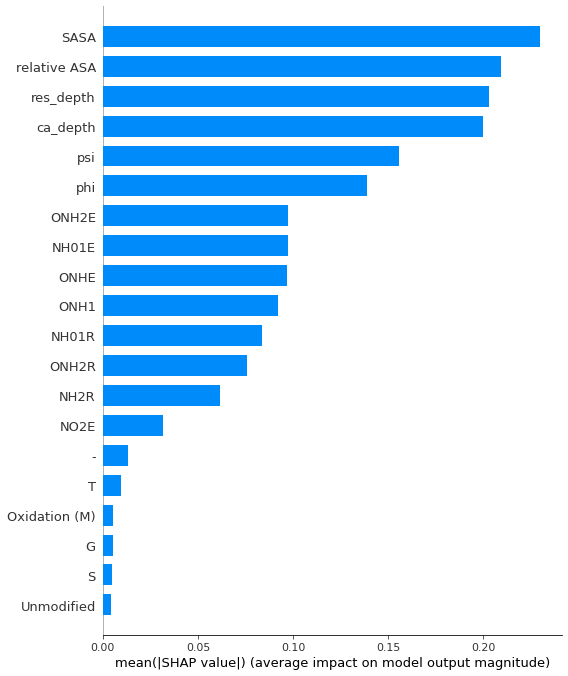

In [94]:
# Generate SHAP values using TreeExplainer
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)

# Plot detailed feature importance
shap.summary_plot(shap_values, X_test, plot_type="bar")
plt.show()

In [95]:
#optimizing hyperpatameters

from sklearn.model_selection import GridSearchCV

# Define the parameter grid for grid search
param_grid = {
    'learning_rate': [0.1, 0.01, 0.001],
    'max_depth': [3, 6, 9]
}

# Perform grid search with cross-validation
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5)
grid_search.fit(X_train, y_train)

# Get the best parameter values and the corresponding model
best_learning_rate = grid_search.best_params_['learning_rate']
best_max_depth = grid_search.best_params_['max_depth']
best_model = grid_search.best_estimator_

# Train the best model on the full training set
best_model.fit(X_train, y_train)

# Evaluate the best model on the test set
y_pred = best_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Best Accuracy:", accuracy)

Best Accuracy: 0.7614235500878734


Accuracy:  0.7614235500878734


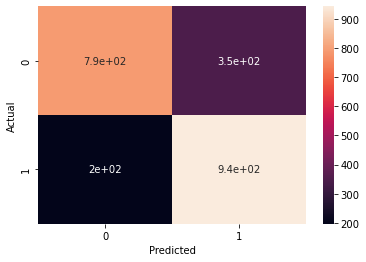

In [96]:
confusion_matrix = pd.crosstab(y_test, y_pred, rownames=['Actual'], colnames=['Predicted'])
sn.heatmap(confusion_matrix, annot=True)
print('Accuracy: ',metrics.accuracy_score(y_test, y_pred))
plt.show()

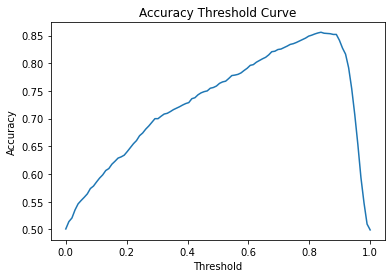

In [97]:
# Evaluate the best model on the test set
y_pred_prob = best_model.predict_proba(X_test)[:, 1]  # Predicted probabilities for the positive class

# Create the accuracy threshold curve
thresholds = np.linspace(0, 1, 100)  # Vary the threshold from 0 to 1
accuracies = []  # Store the accuracies for each threshold

for threshold in thresholds:
    y_pred_threshold = (y_pred_prob >= threshold).astype(int)  # Apply the threshold to the predicted probabilities
    accuracy = accuracy_score(y_test, y_pred_threshold)  # Compute accuracy
    accuracies.append(accuracy)

# Plot the accuracy threshold curve
plt.plot(thresholds, accuracies)
plt.xlabel('Threshold')
plt.ylabel('Accuracy')
plt.title('Accuracy Threshold Curve')
plt.show()

In [98]:
# Get the confidence scores
confidence_scores = best_model.predict_proba(X_test)

# Select the confidence scores for the positive class
positive_scores = confidence_scores[:, 1]


In [99]:
# Compare predictions with truth values
ProteinIDs=df['ProteinID'].tolist()
data_frame=pd.DataFrame({'relative ASA':X_test['relative ASA'] ,'Prediction':y_pred,'Probability':positive_scores})
merged_df = pd.merge(data_frame, df, on='relative ASA')
merged_df = merged_df[['ProteinID', 'start', 'end', 'cleavage_sites', 'Cleavage', 'Prediction','Probability']]
print(merged_df)

       ProteinID  start  end                        cleavage_sites  Cleavage  \
0         Q16204    105  118                        AEQEEEFISNTLFK         0   
1         P35241    449  458                            AFAAQEDLEK         0   
2         Q99732    153  159                               ALLGTYK         0   
3         Q9NUL3     69   84                      ALTESTLPKPVQKPPK         0   
4         Q86UP2    583  607             AQIQQFHSQIAAQTSASVLAEELHK         0   
...          ...    ...  ...                                   ...       ...   
366572    O75822     98  106                                     R         0   
366573    O15523    101  109                             SDYDGIGNR         0   
366574    Q15424    536  549                          DQDDQKPGPSER         1   
366575    P22234    332  367  SNGLGPVMSGNTAYPVISCPPLTPDWGVQDVWSSLR         0   
366576    O75534     65   78                                     R         0   

        Prediction  Probability  
0    

In [100]:
# select rows where the value in Prediction is equal to 1
df_ones = merged_df[merged_df['Prediction'] == 1]

# sort the resulting dataframe by the values in Probability in ascending order
df_ones_sorted = df_ones.sort_values('Probability', ascending=True)

# select the first row with the lowest Probability
result = df_ones_sorted.iloc[0]
threshold=result['Probability']
print(threshold)

0.5003118


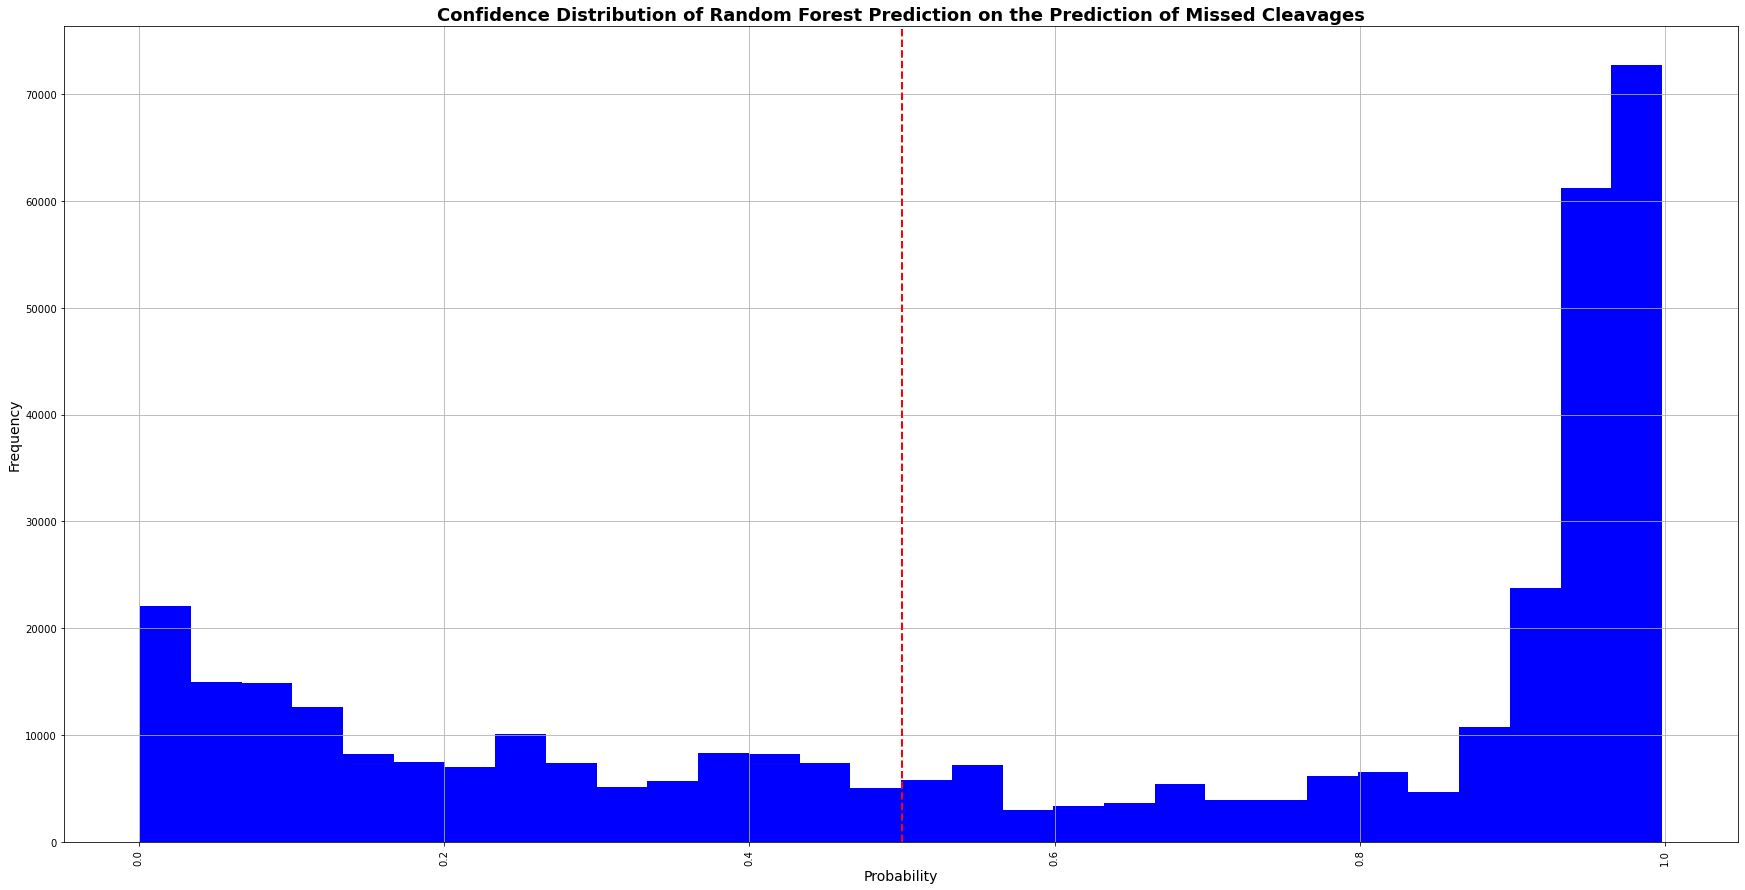

In [101]:
# Sort the Order_df dataframe by the 'end' column
Order_df = merged_df.sort_values('Probability')


# Create a figure and an axis object for the plot
fig, ax1 = plt.subplots(figsize=(30, 15))

# Add a histogram to the axis object
ax1.hist(Order_df['Probability'], bins=30, color='blue')
ax1.set_xlabel('Probability', fontsize=14)
ax1.set_ylabel('Frequency', fontsize=14)
plt.title('Confidence Distribution of Random Forest Prediction on the Prediction of Missed Cleavages', fontsize=18, fontweight='bold')

# Customize the appearance of the plot
ax1.set_ylim(0)  # Set the y-axis limits for the first axis

# Add a vertical line at the threshold value
#threshold = 0.5
ax1.axvline(threshold, color='red', linestyle='dashed', linewidth=2)

# rotate x-axis label
plt.xticks(rotation=90)

# Add grid
plt.grid(True)

# Display plot
plt.show()

In [102]:
# Set the threshold value
threshold = float(input('Input threshold:'))

# Filter the dataframe based on the threshold value
filtered_df = merged_df[merged_df['Probability'] > threshold]

# Print the filtered dataframe
print(filtered_df)

Input threshold: 0.5003118


       ProteinID  start  end                        cleavage_sites  Cleavage  \
0         Q16204    105  118                        AEQEEEFISNTLFK         0   
1         P35241    449  458                            AFAAQEDLEK         0   
2         Q99732    153  159                               ALLGTYK         0   
3         Q9NUL3     69   84                      ALTESTLPKPVQKPPK         0   
4         Q86UP2    583  607             AQIQQFHSQIAAQTSASVLAEELHK         0   
...          ...    ...  ...                                   ...       ...   
366542    O75822     98  106                                     R         0   
366543    O15523    101  109                             SDYDGIGNR         0   
366544    Q15424    536  549                          DQDDQKPGPSER         1   
366545    P22234    332  367  SNGLGPVMSGNTAYPVISCPPLTPDWGVQDVWSSLR         0   
366546    O75534     65   78                                     R         0   

        Prediction  Probability  
0    

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


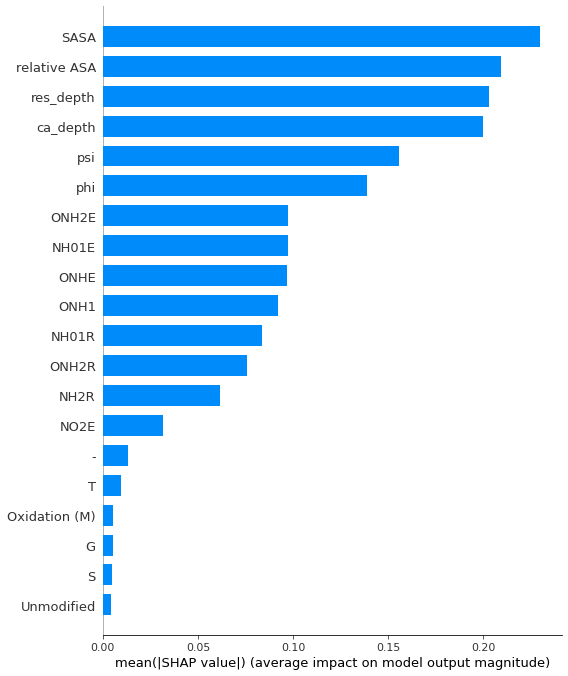

In [103]:
# Generate SHAP values using TreeExplainer
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test, check_additivity=False)

# Plot detailed feature importance
shap.summary_plot(shap_values, X_test, plot_type="bar")
plt.show()

In [104]:

# In conclusion, different datasets & different machines learning models rely on different feature importance which causes differences in the ranking of each feature. However the differences in the feature importance are not significant and choose (top 3 consistant features) are the ones to likely cause trypsisin to cleave or not. Therefore multivariate features influences tryptic cleavage to be missed.


# Try to introduce third class in the dataset for simultaneous missed and correctly cleaved peptides of the same sequence in the dataset. (Data wrangling part)

# implement more interesting dataset retrieved from (https://www.ebi.ac.uk/pride/archive)
# Pride(Pride archive->Orgnaism->Homosapien)